# EZ: Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob as glob
import pdf_ccdf
import h5py
import sys,tqdm
sys.path.append('/home/santiago_b/ez_model/src/')
import model as ez
import scipy.stats as stats

In [2]:
import scipy.special as spec

In [3]:
import scipy.signal as sig

In [4]:
plt.style.use('default')
# plt.style.use('dark_background')
plt.rcParams.update({'font.size': 20})
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams["font.serif"] = "Times New Roman"

In [5]:
def GammaDist(xplt,mean,var):
    theta = var/mean
    k = mean/theta #= mean**2/var
    return theta**(-k)*xplt**(k-1)*np.exp(-xplt/theta) / spec.gamma(k)

def NB(xplt,mean,var):
    p = (var-mean)/(var)
    r = mean**2/(var-mean)
    print(r,p)
    return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r

def GaussDist(xplt,mean,var):
    return (2*np.pi*var)**(-0.5)*np.exp(-(xplt-mean)**2/var/2)

In [6]:
# Threshold
def onoff_dist(T,dt,thresh):
    wt = []
    t_off = dt
    for q in T:
        if (q<=thresh):
            t_off += dt
        else:
            wt.append(t_off)
            t_off = dt

    return np.array(wt)

In [7]:
# Choose output directory
odir = './Figures/'

In [8]:
idirs = ['../1000x200','../200x1000','../Nys/q_50']

In [9]:
leg = {'../1000x200':'Long','../200x1000':'Wide','../Nys/q_50': 'Varying width'}
ms_leg = {'../1000x200':'o','../200x1000':'^','../Nys/q_50': 's'}
color_leg = {'../1000x200':cm.Reds(0.6),'../200x1000':cm.Blues(0.6),'../Nys/q_50': cm.Greens(0.6)}

## List of $q_{in}$ values

In [10]:
q_ins_Ny = []
runs_d = dict([])
for idir in idirs:
    if 'x' in idir:
        dirs = sorted(glob.glob(idir+'/q*'))
        Ny = float(idir.split('x')[1][:])
        runs = []
        for file in dirs:
            run = file.split('/')[2]
            q_in = float(run.split('_')[1].replace('d','.'))
            runs.append(run)
            q_ins_Ny.append(q_in/Ny)
        runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
        print(runs)
        runs_d[idir]=runs
    elif 'q' in idir:
        dirs = sorted(glob.glob(idir+'/Ny*'))
        q_in = float(idir.split('_')[1][:])
        runs = []
        for file in dirs:
            run = file.split('/')[3]
            Ny = int(run.split('_')[1])
            runs.append(run)
            q_ins_Ny.append(q_in/Ny)
        runs = sorted(runs, key=lambda x: int(x.split('_')[1]), reverse=True)
        print(runs)
        runs_d[idir]=runs

q_ins_Ny = np.unique(np.array(q_ins_Ny))
print(q_ins_Ny)

['q_1d000000e+01', 'q_2d000000e+01', 'q_3d000000e+01', 'q_4d000000e+01', 'q_5d000000e+01', 'q_6d000000e+01', 'q_7d000000e+01', 'q_8d000000e+01', 'q_9d000000e+01', 'q_1d000000e+02']
['q_1d000000e+01', 'q_2d000000e+01', 'q_3d000000e+01', 'q_4d000000e+01', 'q_5d000000e+01', 'q_6d000000e+01', 'q_7d000000e+01', 'q_8d000000e+01', 'q_9d000000e+01', 'q_1d000000e+02']
['Ny_3200', 'Ny_1600', 'Ny_800', 'Ny_400', 'Ny_200', 'Ny_100']
[0.01     0.015625 0.02     0.03     0.03125  0.04     0.05     0.06
 0.0625   0.07     0.08     0.09     0.1      0.125    0.15     0.2
 0.25     0.3      0.35     0.4      0.45     0.5     ]


In [11]:
for run in runs[:1]:
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    f = h5py.File(fname,'r')
    print(run)
    for subdat in f:
        print(subdat)
        print(f[subdat].keys())
#         print(subdat['tasks'].keys())
#         print(subdat['scales']['sim_time'][:])
    f.close()

Ny_3200
parameters
<KeysViewHDF5 ['Nx', 'Ny', 'c_0', 'f', 'q_in', 'rho', 'skipmax', 'u_p']>
scalars
<KeysViewHDF5 ['bed_activity', 'e_last', 'e_mid', 'q_mid', 'q_out', 'time', 'tstep']>


In [12]:
# Scale for coloring:
def cscale_qins(q_in,q_ins_Ny):
    maxt = (np.max(q_ins_Ny))
    mint = (np.min(q_ins_Ny))
    return ((q_in) - mint)/(maxt-mint)

In [13]:
# Scale for coloring:
def cscale_qins_log2(q_in,q_ins_Ny):
    maxt = np.log2(np.max(q_ins_Ny))
    mint = np.log2(np.min(q_ins_Ny))
    return (np.log2(q_in) - mint)/(maxt-mint)

In [14]:
# Scale for coloring:
def cscale_qins_sqrt(q_in,q_ins_Ny):
    maxt = np.sqrt(np.max(q_ins_Ny))
    mint = np.sqrt(np.min(q_ins_Ny))
    return (np.sqrt(q_in) - mint)/(maxt-mint)

In [15]:
def nb_calc(set_q):
    """
    Calculates and returns number of active neighbors influencing that site, given e.
    """
    # Set A (what will be the probability matrix) to zero:
    p_temp = np.zeros((set_q.Ny,set_q.Nx))

    # Make sure to exclude points that leave the domain
    dxexcl = set_q.e*set_q.dx_mat+set_q.Xmesh
    edom = set_q.e*(dxexcl < set_q.Nx)

    dxs = np.unique(set_q.dx_mat*edom)
    for rollx in dxs[dxs>0]:
        etemp = edom*(set_q.dx_mat == rollx) # Only places where self.dx_mat == rollx
        p_temp += np.roll(np.roll(etemp,0,axis=0),rollx,axis = 1)
        p_temp += np.roll(np.roll(etemp,1,axis=0),rollx,axis = 1)
        p_temp += np.roll(np.roll(etemp,-1,axis=0),rollx,axis = 1)
        
    return p_temp

In [16]:
def s_calc(set_q,rollx,rolly):
    z_temp = np.copy(set_q.z)

    s=(z_temp-np.roll(np.roll(z_temp,rolly,axis=0),rollx,axis = 1))/rollx

    return s

def slope_calc(set_q):
    p_temp = np.array([])

    dxs = np.unique(set_q.dx_mat)
    for rollx in dxs[dxs>0]:
        p_temp = np.hstack(s_calc(set_q,rollx,0).flatten())
        p_temp = np.hstack(s_calc(set_q,rollx,1).flatten())
        p_temp = np.hstack(s_calc(set_q,rollx,-1).flatten())
        
    return p_temp

$$ q^*_{in} = \frac{q_{in}}{\tilde{\Delta t}_{s}} \frac{4}{3} \pi \frac{1}{\tilde{b}} \left(\frac{\rho_w}{\rho_s - \rho_w}\right)^{1/2}$$

# Averages

In [18]:
slopes_bed = dict([])
# slopes_bed_2 = dict([])
# slopes_bed_2_err = dict([])
neigh_d = dict([])
neigh_2_d = dict([])
skewness_d = dict([])
kurt_d = dict([])
q8in_d = dict([])
qin_d = dict([])
Ny_d = dict([])
Nx_d = dict([])
ba_d = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
#     slopes_2_l = []
#     slopes_2_err_l = []
    q8in_l = []
    qin_l = []
    neigh_l = []
    neigh_2_l = []
    Ny_l = []
    Nx_l = []
    skewness_l = []
    ba_l = []
    kurt_l = []
    
    for ii,run in enumerate(runs_d[idir]):
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        fb = 0.3
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]
        q = file['scalars']['q_out'][()][500:] # Start a little bit ahead because there's some transient upon initialization
        file.close()

        # Initialize
        set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)

        # Load data:
        set_q.load_data(str(glob.glob(idir+'/'+run+'/*_state.h5')[0]))

        q8in_l.append(set_q.q8in)
        qin_l.append(set_q.q_in)
        Nx_l.append(Nx)
        Ny_l.append(Ny)
        ba_l.append(np.mean(np.sort(q)[-10:]))

##############
### SLOPES ###
##############

        # based on the y-averaged bed
        z_avg = np.mean(set_q.z[:,10:-10],axis=0)
        x = np.arange(len(z_avg))
        m,b = np.polyfit(x,z_avg,1)
        slopes_l.append(m)

        # Based on individual slopes (with multiple 'rollx' and 'rolly') between points. More of how the slope is 'felt' by algorithm
#         slopes = slope_calc(set_q)
#         slopes_2_l.append(np.mean(slopes[slopes<0]))
#         slopes_2_err_l.append(np.std(slopes[slopes<0])/np.sqrt(np.size(slopes[slopes<0])))
#         plt.hist(slopes[slopes<0],density=True,bins=20)
#         plt.show()
        
#################
### NEIGHBORS ###
#################
        
        # v1
        p_temp= nb_calc(set_q)
#         plt.imshow(set_q.z/np.mean(set_q.z,axis=0),vmin=0.75,vmax=1.25,cmap=cm.bwr)
#         plt.colorbar()
#         plt.show()
#         plt.imshow(set_q.z-np.mean(set_q.z,axis=0),vmin=-60,vmax=60,cmap=cm.viridis)
#         plt.colorbar()
#         plt.show()
#         plt.figure(dpi=300)
#         plt.imshow(p_temp,aspect=1)
# #         plt.colorbar()
#         ax=plt.gca()
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         ax.tick_params(axis='both',bottom=False,left=False)
#         plt.show()Y
#         neigh_l.append(np.mean(p_temp[p_temp>0]))
#         neigh_2_l.append(np.var(p_temp))

#         neigh_l.append(3*np.mean(ba))#3*np.mean(set_q.e))
        
        # v2
        neigh_2_l.append(q_in*(Ny*skipmax*c_0*(1-fb*(q_in/Ny/skipmax))*(1+m**2)**(1/2.))**(-1.))
        
################
### SKEWNESS ###
################
        skewness_l.append(stats.skew(q))
        kurt_l.append(stats.kurtosis(q))
        

    slopes_bed[idir] = np.array(slopes_l)
#     slopes_bed_2[idir] = np.array(slopes_2_l)
#     slopes_bed_2_err[idir] = np.array(slopes_2_err_l)
    q8in_d[idir] = np.array(q8in_l)
    qin_d[idir] = np.array(qin_l)
    neigh_d[idir] = np.array(neigh_l)
    neigh_2_d[idir] = np.array(neigh_2_l)
    skewness_d[idir] = np.array(skewness_l)
    kurt_d[idir] = np.array(kurt_l)
    Nx_d[idir] = np.array(Nx_l)
    Ny_d[idir] = np.array(Ny_l)
    ba_d[idir] = np.array(ba_l)
    

Working on ../1000x200
Working on ../200x1000
Working on ../Nys/q_50


# Figure 2
Demonstration of 'Long' runs at equilibrium

### Figure 2 a

In [148]:
runs_plt = [
    'q_1d000000e+01', 
    'q_2d000000e+01', 
#     'q_3d000000e+01', 
    'q_4d000000e+01', 
#     'q_5d000000e+01', 
#     'q_6d000000e+01', 
#     'q_7d000000e+01', 
    'q_8d000000e+01', 
#     'q_9d000000e+01',
#     'q_1d000000e+02',
]

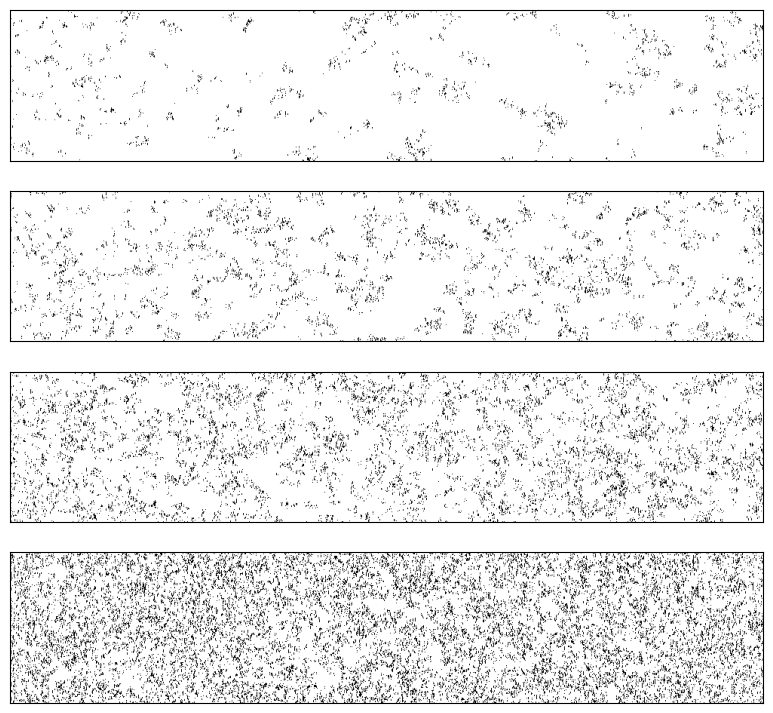

In [150]:
profs = dict([])

idir = '../1000x200'

size = 3

#############################################################
### Representative e and z_avg profiles (for "Long" runs) ###
#############################################################
fig,axs = plt.subplots(4,1,figsize=(size*set_q.Nx/set_q.Ny,3*size))
for ii,run in enumerate(runs_plt):
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    fb = 0.3
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    u_p = file['parameters']['u_p'][()]
    skipmax = file['parameters']['skipmax'][()]
    q = file['scalars']['e_mid'][()][500:] # Start a little bit ahead because there's some transient upon initialization
    ba = file['scalars']['bed_activity'][()][500:]
    file.close()

    # Initialize
    set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)

    # Load data:
    set_q.load_data(str(glob.glob(idir+'/'+run+'/*_state.h5')[0]))
    
    ######################
    ### Snapshots of e ###
    ######################
    axs[ii].imshow(set_q.e,vmin=0,vmax=1,cmap='binary',aspect=1)
    axs[ii].set_xticklabels([])
    axs[ii].set_yticklabels([])
    axs[ii].tick_params(axis='both',bottom=False,left=False)
    # ax1.set_title("Entrainment Field")
    
    profs[run]=np.mean(set_q.z,axis=0)

# plt.savefig('./Figures/Figure_2_a.png',dpi=300,bbox_inches='tight')
plt.show()

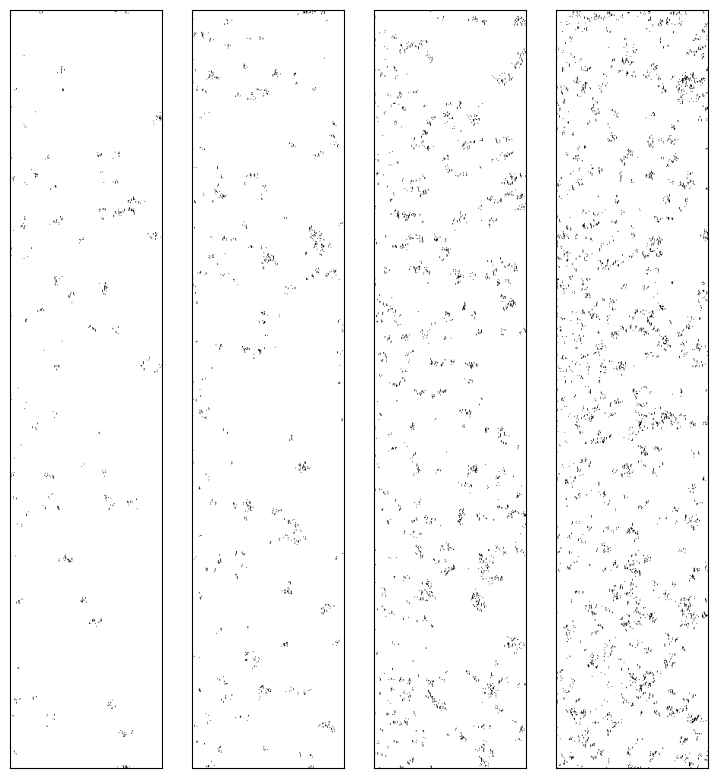

In [152]:
profs = dict([])

idir = '../200x1000'

size = 3

#############################################################
### Representative e and z_avg profiles (for "Long" runs) ###
#############################################################
fig,axs = plt.subplots(1,4,figsize=(3*size,size*set_q.Ny/set_q.Nx))
for ii,run in enumerate(runs_plt):
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    fb = 0.3
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    u_p = file['parameters']['u_p'][()]
    skipmax = file['parameters']['skipmax'][()]
    q = file['scalars']['e_mid'][()][500:] # Start a little bit ahead because there's some transient upon initialization
    ba = file['scalars']['bed_activity'][()][500:]
    file.close()

    # Initialize
    set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)

    # Load data:
    set_q.load_data(str(glob.glob(idir+'/'+run+'/*_state.h5')[0]))
    
    ######################
    ### Snapshots of e ###
    ######################
    axs[ii].imshow(set_q.e,vmin=0,vmax=1,cmap='binary',aspect=1)
    axs[ii].set_xticklabels([])
    axs[ii].set_yticklabels([])
    axs[ii].tick_params(axis='both',bottom=False,left=False)
    # ax1.set_title("Entrainment Field")
    
    profs[run]=np.mean(set_q.z,axis=0)

# plt.savefig('./Figures/Figure_2_a.png',dpi=300,bbox_inches='tight')
plt.show()

In [153]:
runs_plt_2 = [
    'Ny_3200',
    'Ny_1600',
    'Ny_800',
#     'Ny_400',
    'Ny_200',
#     'Ny_100',
]

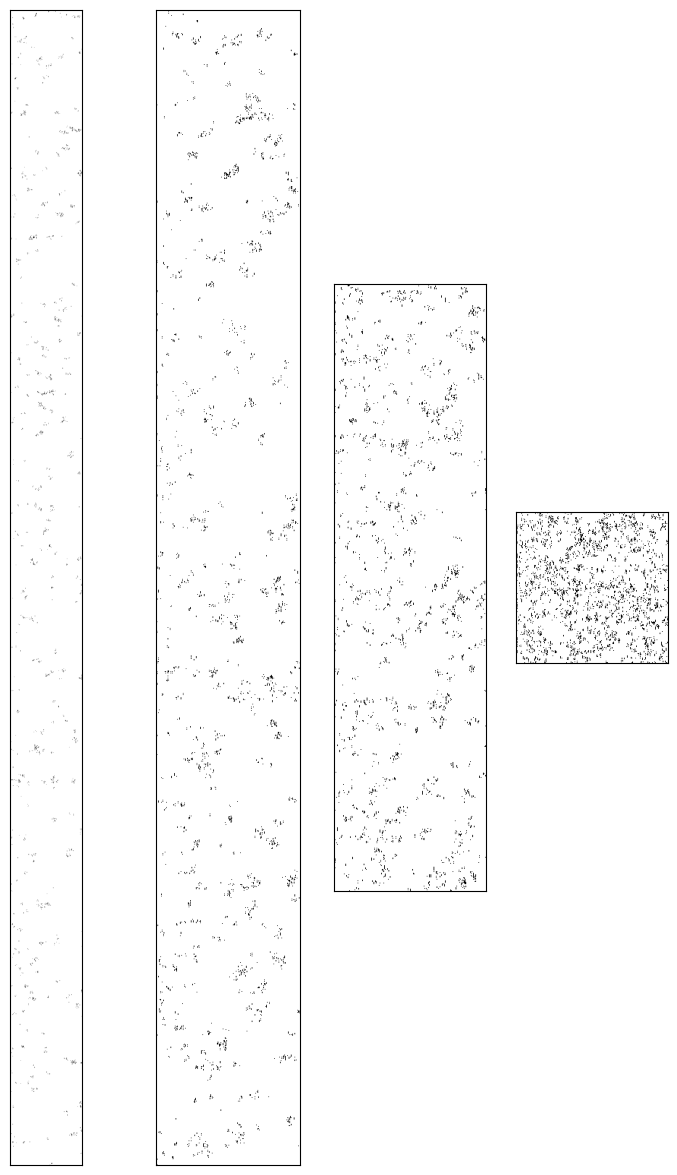

In [154]:
profs = dict([])

idir = '../Nys/q_50'

size = 3

#############################################################
### Representative e and z_avg profiles (for "Long" runs) ###
#############################################################
fig,axs = plt.subplots(1,4,figsize=(3*size,5*size))
for ii,run in enumerate(runs_plt_2):
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    fb = 0.3
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    u_p = file['parameters']['u_p'][()]
    skipmax = file['parameters']['skipmax'][()]
    q = file['scalars']['e_mid'][()][500:] # Start a little bit ahead because there's some transient upon initialization
    ba = file['scalars']['bed_activity'][()][500:]
    file.close()

    # Initialize
    set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)

    # Load data:
    set_q.load_data(str(glob.glob(idir+'/'+run+'/*_state.h5')[0]))
    
    ######################
    ### Snapshots of e ###
    ######################
    axs[ii].imshow(set_q.e,vmin=0,vmax=1,cmap='binary',aspect=1)#5*set_q.Nx/set_q.Ny)
    axs[ii].set_xticklabels([])
    axs[ii].set_yticklabels([])
    axs[ii].tick_params(axis='both',bottom=False,left=False)
    # ax1.set_title("Entrainment Field")
    
    profs[run]=np.mean(set_q.z,axis=0)

# plt.savefig('./Figures/Figure_2_a.png',dpi=300,bbox_inches='tight')
plt.show()

### Figure 2 b

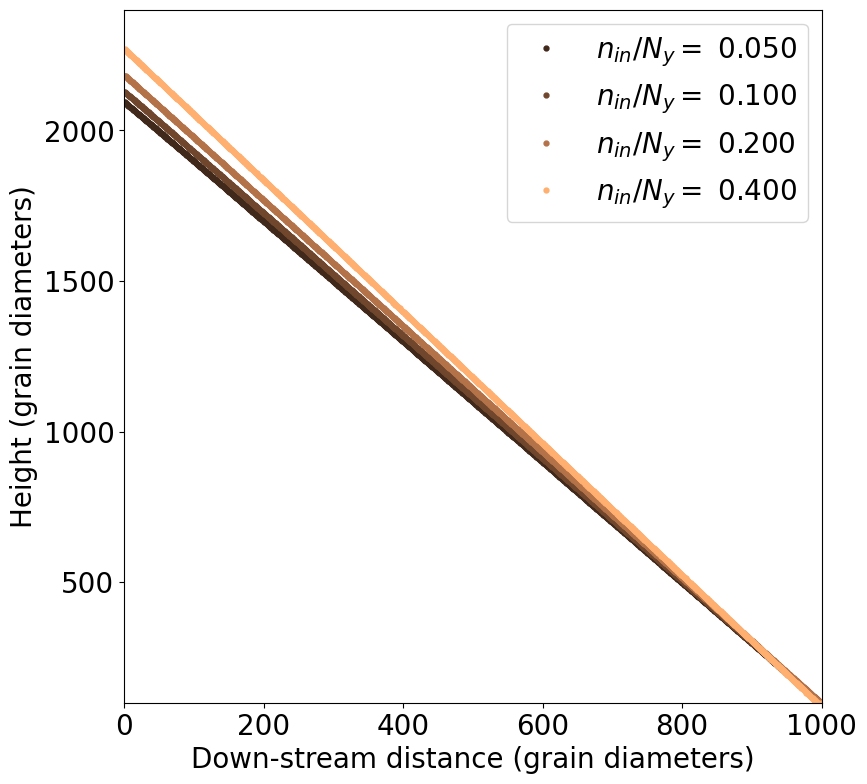

In [20]:
plt.figure(2,figsize=(9,9)) # to match size of previous one
for ii,run in enumerate(runs_plt):
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    fb = 0.3
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    u_p = file['parameters']['u_p'][()]
    skipmax = file['parameters']['skipmax'][()]
    q = file['scalars']['e_mid'][()][500:] # Start a little bit ahead because there's some transient upon initialization
    ba = file['scalars']['bed_activity'][()][500:]
    file.close()
    
    plt.plot(profs[run],color = cm.copper(cscale_qins_sqrt(q_in/Ny,q_ins_Ny)),label = r"$n_{in}/N_y =$ %.3f" % (q_in/Ny),ls='',marker='.',ms=7)
    
plt.xlim(0,1000)
plt.ylim(set_q.bed_h,100+2.3*1000)
plt.xlabel(r"Down-stream distance (grain diameters)")
plt.ylabel(r"Height (grain diameters)")
plt.legend()
# plt.savefig('./Figures/Figure_2_b.png',dpi=150,bbox_inches='tight')
plt.show()

### Figure 2 c

In [ ]:
plt.figure(figsize=(9,9))
for dirr in slopes_bed:
    plt.plot(qin_d[dirr]/(Ny_d[dirr]),-slopes_bed[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)
#     plt.errorbar(qin_d[dirr]/(Ny_d[dirr]),-slopes_bed_2[dirr],yerr=slopes_bed_2_var[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)
#     plt.plot(qin_d[dirr]/(Ny_d[dirr]),np.sqrt((3*c_0*(1-fb*neigh_d[dirr]/3))**(-2) - 1),marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=5)
    
for run in runs_plt:
    q_in = float(run.split('_')[1].replace('d','.'))
    x = np.arange(len(profs[run]))
    m,b = np.polyfit(x,profs[run],1)
    plt.scatter(q_in/200,-m,marker='o',s=400,color = cm.copper(cscale_qins_sqrt(q_in/200,q_ins_Ny)),zorder=-1)
    
plt.plot(q_ins_Ny, np.sqrt((1/(3*c_0*(1-fb*(np.array(q_ins_Ny/3.)))))**2 - 1),'--r',label = 'Prediction (Shifted)') # +0.30
plt.legend(fontsize=18,framealpha=0)#loc=(1.01,0.2))
plt.xlabel("$n_{in}/N_y$")
# plt.xlabel("$c_0$")
plt.ylabel("Bed Slopes")
# plt.ylabel("Avg $c$")
plt.savefig('./Figures/Figure_2_c_v2.png',dpi=150,bbox_inches='tight')
plt.show()

Where do we fail? The prediction is based on the fact that we assume $n_{in}/skipmax$ in each row, however, this doesn't seem to be true. The average is lower. Why, though?

# Figure 3

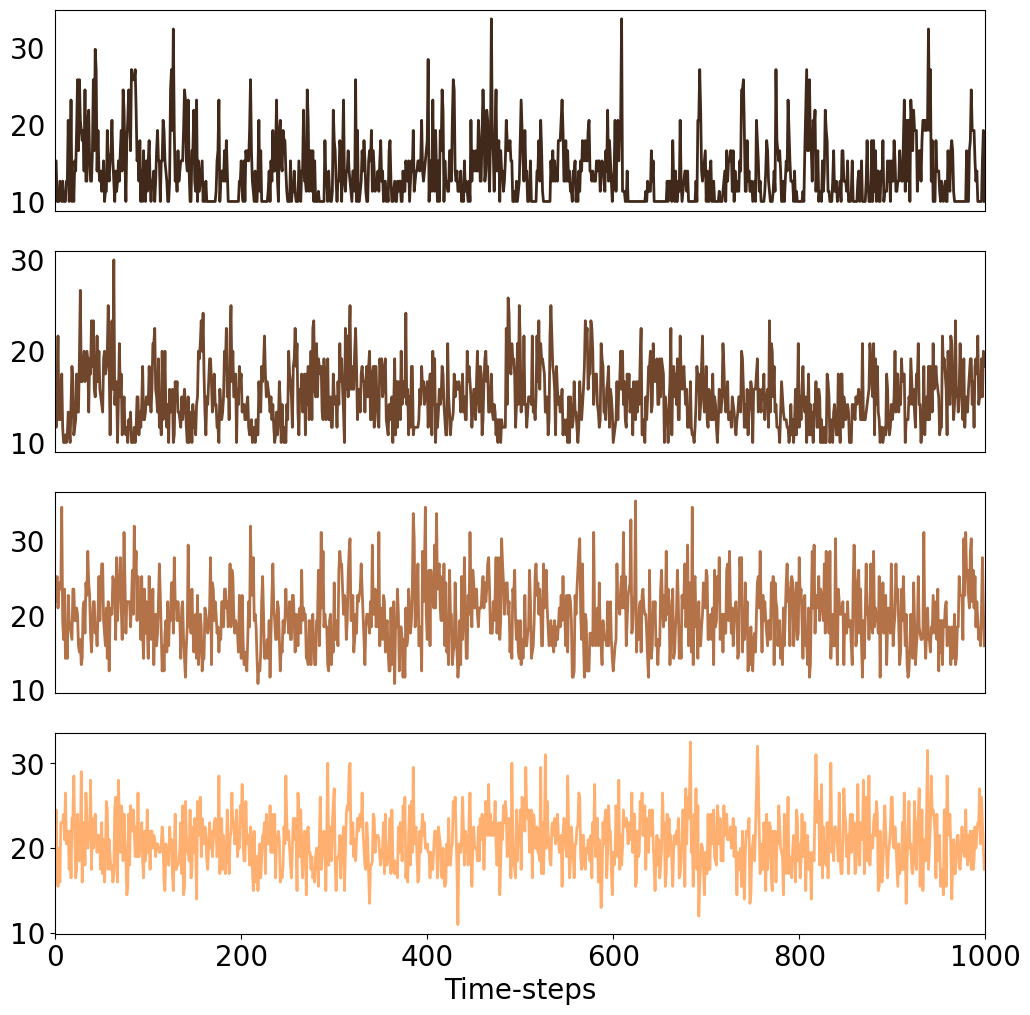

In [101]:
profs = dict([])

idir = '../1000x200'

size = 3

#############################################################
### Representative e and z_avg profiles (for "Long" runs) ###
#############################################################
fig,axs = plt.subplots(4,1,figsize=(size*4,size*4))
for ii,run in enumerate(runs_plt):
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    fb = 0.3
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    u_p = file['parameters']['u_p'][()]
    skipmax = file['parameters']['skipmax'][()]
    q = file['scalars']['e_last'][()][500:] # Start a little bit ahead because there's some transient upon initialization
#     ba = file['scalars']['bed_activity'][()][500:]
    file.close()

    # Initialize
    set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)

    # Load data:
    set_q.load_data(str(glob.glob(idir+'/'+run+'/*_state.h5')[0]))
    
    ######################
    ### Snapshots of e ###
    ######################
    axs[ii].plot(q[600:1600]/np.mean(q),color = cm.copper(cscale_qins_sqrt(q_in/Ny,q_ins_Ny)),label = r"$n_{in}/N_y =$ %.3f" % (q_in/Ny),ls='-',lw=2.)
    axs[ii].set_xlim(0,1000)
    axs[ii].set_yticklabels([0,10,20,30,40,50,60])
    if ii<3:
        axs[ii].set_xticklabels([])
        axs[ii].tick_params(axis='both',bottom=False,left=False)
    else:
        axs[ii].set_xlabel("Time-steps")
        axs[ii].set_ylabel("")
        
# plt.savefig('./Figures/Figure_3_a.png',dpi=300,bbox_inches='tight')
plt.show()

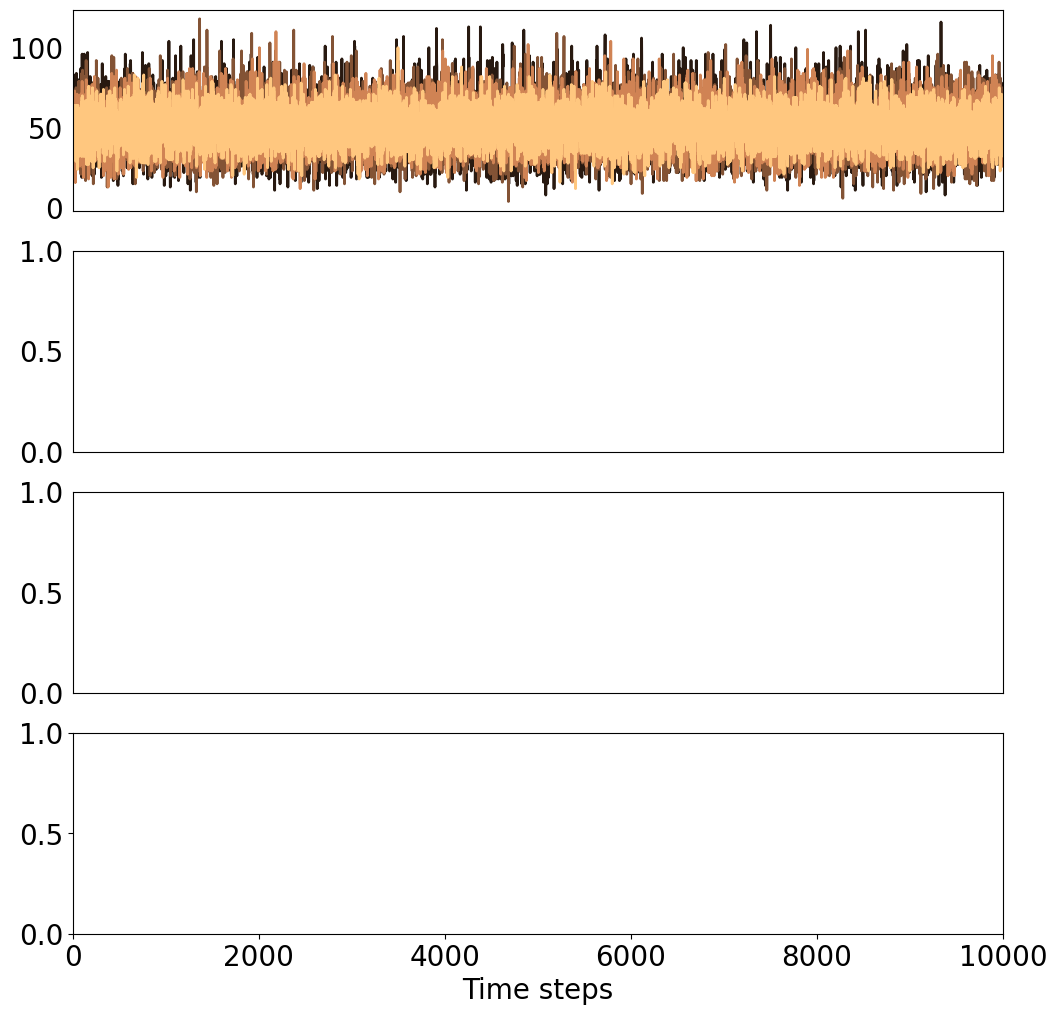

In [102]:
profs = dict([])

idir = '../Nys/q_50'

size = 3

#############################################################
### Representative e and z_avg profiles (for "Long" runs) ###
#############################################################
fig,axs = plt.subplots(4,1,figsize=(size*4,size*4))
for ii,run in enumerate(runs_plt_2):
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    fb = 0.3
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    u_p = file['parameters']['u_p'][()]
    skipmax = file['parameters']['skipmax'][()]
    q = file['scalars']['q_out'][()][500:] # Start a little bit ahead because there's some transient upon initialization
#     ba = file['scalars']['bed_activity'][()][500:]
    file.close()

    # Initialize
    set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)

    # Load data:
    set_q.load_data(str(glob.glob(idir+'/'+run+'/*_state.h5')[0]))
    
    ######################
    ### Snapshots of e ###
    ######################
    strt = 1000
    dt = 10000
    axs[0].plot(q[strt:strt+dt],color = cm.copper(cscale_qins_sqrt(q_in/Ny,q_ins_Ny)),label = r"$n_{in}/N_y =$ %.3f" % (q_in/Ny),ls='-',lw=2.)
    axs[ii].set_xlim(0,dt)
#     axs[ii].set_yticklabels([0,10,20,30,40,50,60])
    if ii<3:
        axs[ii].set_xticklabels([])
        axs[ii].tick_params(axis='both',bottom=False,left=False)
    else:
        axs[ii].set_xlabel("Time steps")
        axs[ii].set_ylabel("")
        
# plt.savefig('./Figures/Figure_3_a.png',dpi=300,bbox_inches='tight')
plt.show()

## Max sizes

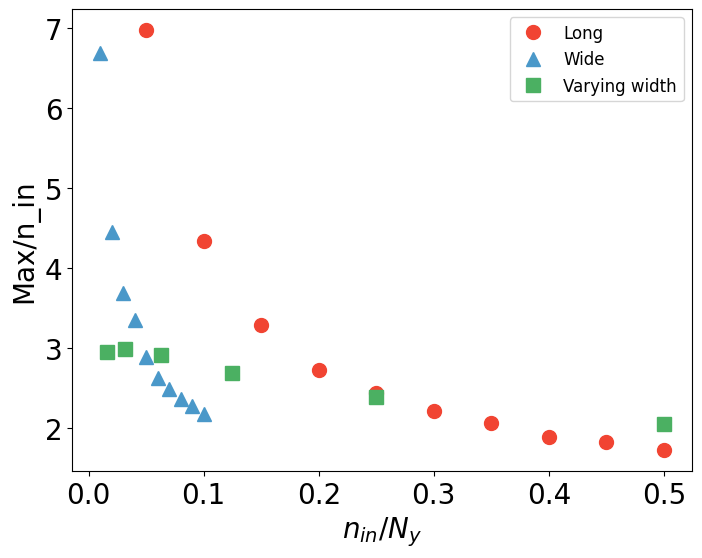

In [119]:
plt.figure(figsize=(8,6))
for dirr in neigh_d:
    plt.plot(qin_d[dirr]/Ny_d[dirr],ba_d[dirr]/qin_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10) #based on slope prediction

# plt.plot(q_ins_Ny,q_ins_Ny,'--r',label='1:1')
plt.legend(fontsize=12)#loc=(1.01,0.2))
plt.xlabel("$n_{in}/N_y$")
# plt.ylim(0,3)
# plt.xlabel("$c_0$")
# plt.ylabel("AN")
plt.ylabel('Max/n_in')
# plt.ylabel("Avg $c$")
plt.show()

## Avg Neighbors

Here we calculate the number of active neighbors _needed_ to maintain equilibrium at this slope and $n_{in}$.

$$ \# AN = \frac{\langle e \rangle}{3c_0(1-f_b\langle e \rangle)\sqrt{1+s^2}}$$

but thinking of steady state, we know that 

$$ \# AN = \frac{3 \sum e}{N_x N_y} = 3 \langle e \rangle \approx \frac{n_{in}}{N_y}$$

Since we expect $\sum e = N_x \sum_{row} e \approx N_x n_{in}/skipmax$, where $skipmax=3$ and the other 3 comes from the fact that each active grain acts as a neighbor to exactly three other grains.

So we can see how these compare.

In [27]:
plt.figure(figsize=(8,6))
for dirr in neigh_d:
#     plt.plot(qin_d[dirr]/(Ny_d[dirr]),neigh_2_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr]+' Slope-based',c=color_leg[dirr],ms=10) #based on slope prediction
    plt.plot(qin_d[dirr]/(Ny_d[dirr]),1/(c_0*(1-fb*neigh_d[dirr])*np.sqrt(1+slopes_bed[dirr]**2)),marker = ms_leg[dirr],ls='',label = leg[dirr]+' Slope-based',c=color_leg[dirr],ms=10) #based on slope prediction
#     plt.plot(qin_d[dirr]/(Ny_d[dirr]),neigh_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr]+' Bed activity-based',c=color_leg[dirr],ms=5) # based on actual measurement

# plt.plot(q_ins_Ny,q_ins_Ny,'--r',label='1:1')
plt.legend(fontsize=12)#loc=(1.01,0.2))
plt.xlabel("$n_{in}/N_y$")
# plt.ylim(0,3)
# plt.xlabel("$c_0$")
# plt.ylabel("AN")
plt.ylabel('AN/Predicted')
# plt.ylabel("Avg $c$")
plt.show()

ValueError: operands could not be broadcast together with shapes (0,) (10,) 

<Figure size 800x600 with 0 Axes>

There's something I don't understand here. It has probably got something to do with correlations and such. Obviously we're close to the naive value, but we're not exactly there yet. 

Another way to formulate things is by assuming that, $\# A N = \sum_{NN} e_{NN} = \langle e \rangle \# NN \approx n_{in}/(skipmax N_y) \# NN$, and looking at the _total_ number of neighbors. This 
$$ \# NN = \frac{1}{c_0(1-f_b(n_{in}/(skipmax N_y)))\sqrt{1+s^2}}$$

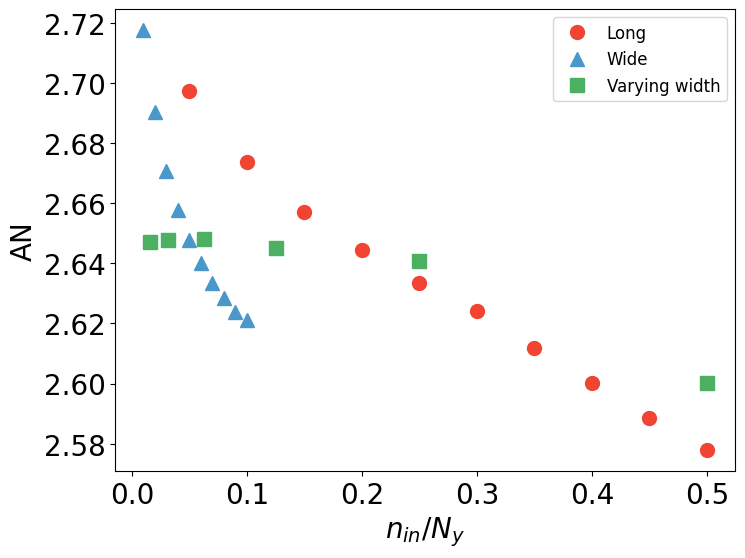

In [52]:
plt.figure(figsize=(8,6))
for dirr in neigh_d:
    plt.plot(qin_d[dirr]/(Ny_d[dirr]),neigh_2_d[dirr]*(3*Ny_d[dirr])/qin_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10) #based on slope prediction
#     plt.plot(qin_d[dirr]/(Ny_d[dirr]),neigh_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr]+' Bed activity-based',c=color_leg[dirr],ms=5) # based on actual measurement

# plt.plot(q_ins_Ny,q_ins_Ny,'--r',label='1:1')
plt.legend(fontsize=12)#loc=(1.01,0.2))
plt.xlabel("$n_{in}/N_y$")
# plt.ylim(0,3)
# plt.xlabel("$c_0$")
# plt.ylabel("AN")
plt.ylabel('AN')
# plt.ylabel("Avg $c$")
plt.show()

Why do the number of neighbors _decrease_ ? Is it because the grains are more uniformly distributed and less avalanches? (which tend to cluster grains together) But then shouldn't the 'wide' runs also be constant? Why is there a decrease?

### We're honestly pretty close to the expected value of 3, but still off, and I cannot explain why there is a dependence on $n_{in}/ N_y$ for the cases of Long and Wide runs.

## Bed Slopes

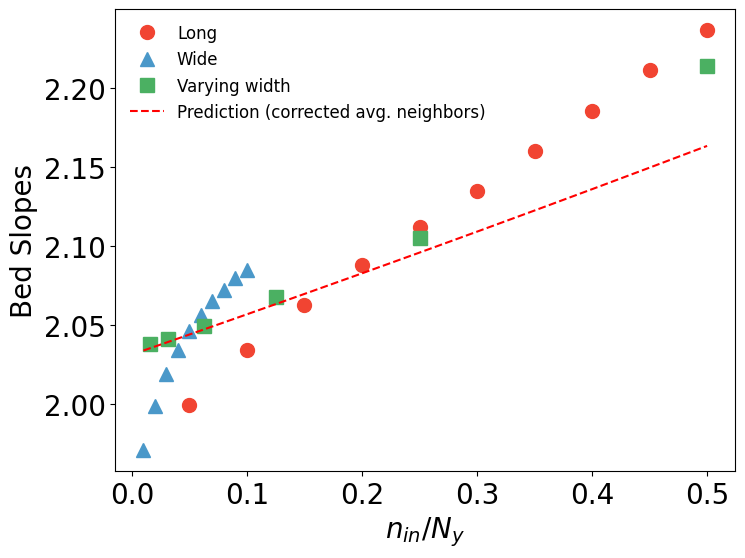

In [22]:
plt.figure(figsize=(8,6))
for dirr in slopes_bed:
    plt.plot(qin_d[dirr]/Ny_d[dirr],-slopes_bed[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)
    
plt.plot(q_ins_Ny, np.sqrt((1/(2.65*c_0*(1-fb*(np.array(q_ins_Ny/3.)))))**2 - 1),'--r',label = 'Prediction (corrected avg. neighbors)')
plt.legend(fontsize=12,framealpha=0)#loc=(1.01,0.2))
plt.xlabel("$n_{in}/N_y$")
# plt.ylim(0,2.5)
# plt.xlabel("$c_0$")
plt.ylabel("Bed Slopes")
# plt.ylabel("Avg $c$")
# plt.savefig('./Figures/Figure_2_c.png',dpi=150,bbox_inches='tight')
plt.show()

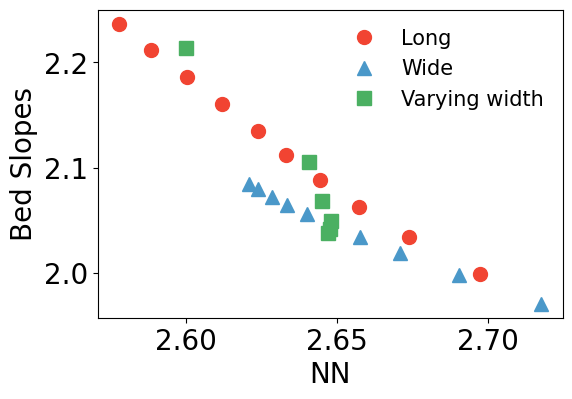

In [50]:
plt.figure(figsize=(6,4))
for dirr in slopes_bed:
    plt.plot(neigh_2_d[dirr],-slopes_bed[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)

# neighs = np.linspace(np.min(neigh_d['../Nys/q_50']),np.max(neigh_d['../Nys/q_50']),len(q_ins_Ny))
# plt.plot(neighs, np.sqrt((1/(neighs*c_0*(1-fb*(np.array(0.1)))))**2 - 1),'--r',label = 'Theory')
plt.legend(fontsize=15,framealpha=0)#,loc=2)
# plt.xlabel("$n_{in}/N_y$")
plt.xlabel("NN")
# plt.xlabel("$c_0$")
plt.ylabel("Bed Slopes")
# plt.ylabel("Avg $c$")
# plt.savefig('./Figures/Figure_2_c.png',dpi=150,bbox_inches='tight')
plt.show()

## Skewness

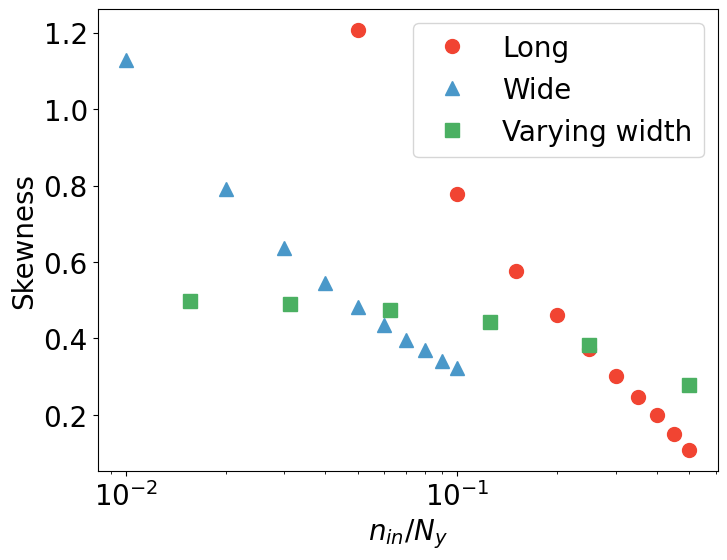

In [46]:
plt.figure(figsize=(8,6))
for dirr in neigh_d:
    plt.semilogx(qin_d[dirr]/Ny_d[dirr],skewness_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)
plt.legend()#loc=(1.01,0.2))
plt.xlabel("$n_{in}/N_y$")
# plt.ylim(0.2,0.6)
# plt.xlabel("$c_0$")
plt.ylabel("Skewness")
# plt.ylabel("Avg $c$")
plt.show()

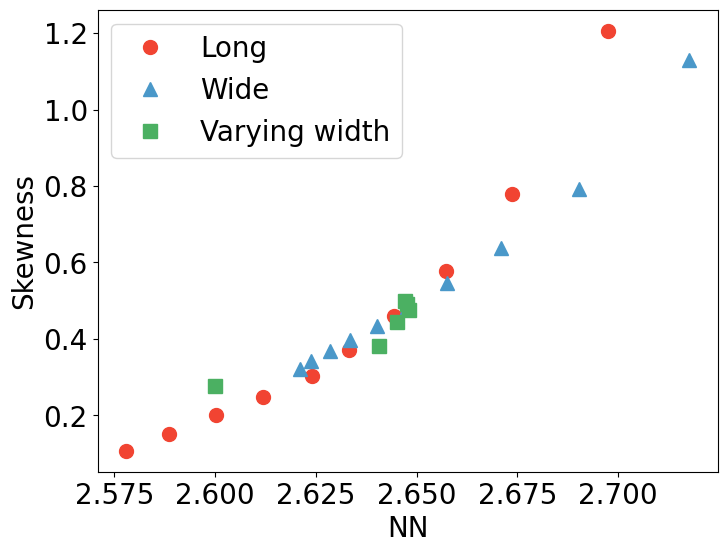

In [49]:
plt.figure(figsize=(8,6))
for dirr in neigh_d:
    plt.plot(neigh_2_d[dirr],skewness_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)
plt.legend()#loc=(1.01,0.2))
plt.xlabel("NN")
# plt.ylim(0.2,0.6)
# plt.xlabel("$c_0$")
plt.ylabel("Skewness")
# plt.ylabel("Avg $c$")
plt.show()

What makes the skewness collapse? In other words, what does the skewness truly depend on?

**Theory 1:** Skewness goes to zero because there are more independent avalanches, leading to an approach to the central limit theorem. _Prediction:_ Things shouldn't depend strongly on $N_y$ and should depend only on the _number_ of independent avalanches, set by $n_{in}$.

**Theory 2:** Skewness goes to zero because the avalanches begin to **overlap**. _Prediction:_ Things should also depend on how much 'space' the avalanches have to develop. Therefore, it should depend on $1/N_y$ for a fixed $n_{in}$.


In the previous figure, looking at the number of neighbors, we see that they kind of increase for $n_{in}/N_y > 0.1$. This would suggest that avalanches are not merging below this number. This would predict that the runs with constant $n_{in}$ but varying $N_y$ should not depend on $N_y$ below this number.

-22.8668801787905 0.5031421443132749


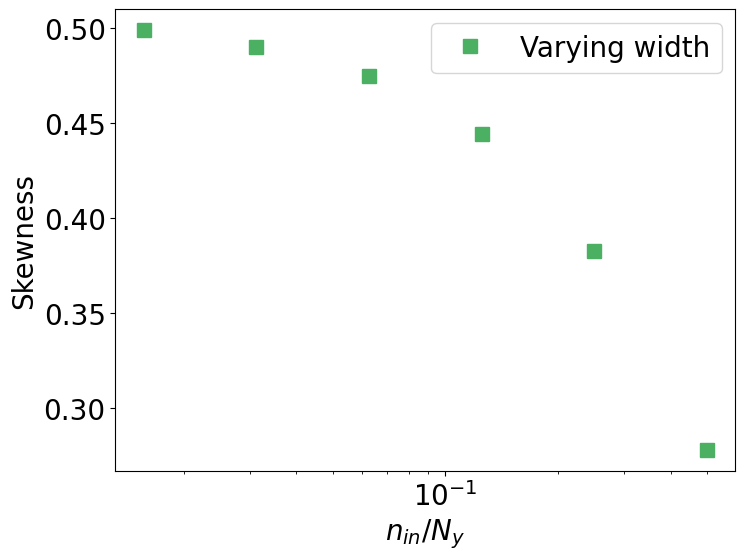

In [98]:
plt.figure(figsize=(8,6))
for dirr in ['../Nys/q_50']:
    plt.semilogx(qin_d[dirr]/Ny_d[dirr],skewness_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)
    if 'q' in dirr:
        m,b = np.polyfit(1/Ny_d[dirr],skewness_d[dirr],1)
        print(m,b)
# plt.axvline(x=1/100.,color='k',ls='--')
plt.legend()#loc=(1.01,0.2))
plt.xlabel("$n_{in}/N_y$")
# plt.ylim(0.2,0.6)
# plt.xlabel("$c_0$")
plt.ylabel("Skewness")
# plt.ylabel("Avg $c$")
plt.show()

In this case we keep $n_{in}$ constant. The CLT argument doesn't hold here, and any variation in $N_y$ is due to overlapping avalanches. We see the effect of overlapping avalanches in all cases, but it's very weak for $n_{in}/N_y < 0.1$.

When considering all the runs, the runs to the left of $n_{in}/N_y$ should be free of overlapping avalanche effects. They should therefore _only_ depend on $n_{in}$. I will now be coloring the points that satisfy this criteria. 

-0.5471445188901682 0.6081774615594575


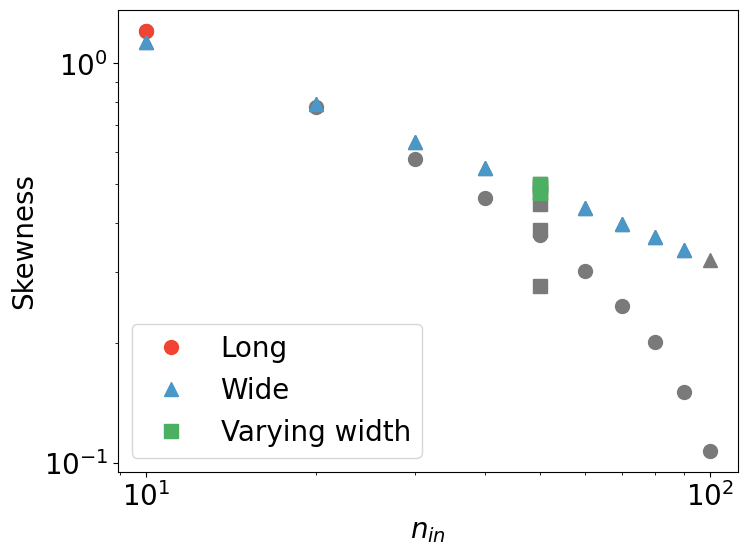

In [99]:
plt.figure(figsize=(8,6))
for dirr in neigh_d:
#     print(leg[dirr])
    cond = qin_d[dirr]/Ny_d[dirr] < 0.1
    plt.loglog(qin_d[dirr],skewness_d[dirr],marker = ms_leg[dirr],ls='',c=cm.Greys(0.6),ms=10)
    plt.loglog(qin_d[dirr][cond],skewness_d[dirr][cond],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)
    if dirr == '../200x1000':
        m,b = np.polyfit(np.log10(qin_d[dirr]),np.log10(skewness_d[dirr]),1)
        print(m,b)
plt.legend()#loc=(1.01,0.2))
plt.xlabel("$n_{in}$")
# plt.xlabel("$c_0$")
plt.ylabel("Skewness")
# plt.ylabel("Avg $c$")
plt.show()

Interestingly, we see that the colored points fall on the same curve and follow an inverse square root in $n_{in}$!

$$ S \sim n_{in}^{-1/2} \text{ for non-overlapping avalanches}$$

Therefore, when considering the effects of overlapping avalanches, we might expect some dependence on $n_{in}/N_y$ (the amount of 'room' each avalanche has) to look like,

$$ n_{in}^{0.5} S  \sim f(n_{in}/N_y)$$

Let's try this.

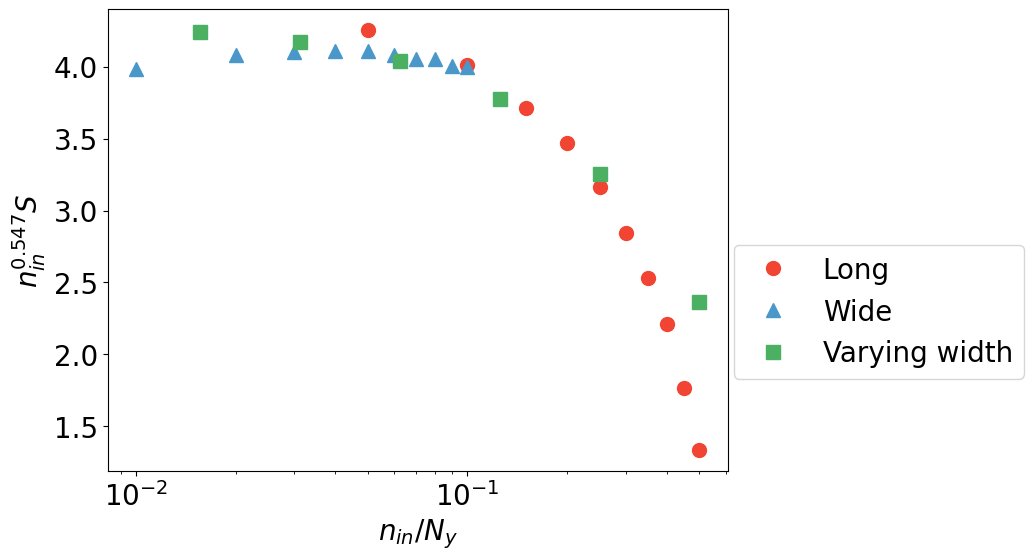

In [102]:
plt.figure(figsize=(8,6))
for dirr in neigh_d:
    plt.semilogx(qin_d[dirr]/Ny_d[dirr],qin_d[dirr]**(-m)*skewness_d[dirr],marker = ms_leg[dirr],ls='',label = leg[dirr],c=color_leg[dirr],ms=10)
#     if 'q' in dirr:
#         m,b = np.polyfit(1/Ny_d[dirr],skewness_d[dirr],1)
#         print(m,b)
# plt.axvline(x=1/100.,color='k',ls='--')
plt.legend(loc=(1.01,0.2))
plt.xlabel("$n_{in}/N_y$")
# plt.ylim(0.2,0.6)
# plt.xlabel("$c_0$")
plt.ylabel(r"$n_{in}^{%.3f} S$" % (-m))
# plt.ylabel("Avg $c$")
plt.show()

Honestly, it seems to collapse the curves surprisingly well! It tells us that overlapping avalanches start occuring once $n_{in}/N_y > 0.1$. This roughly coincides with the 'average number of neighbors' plots, which start rising around this point as well.

# Power spectrum

Working on ../1000x200


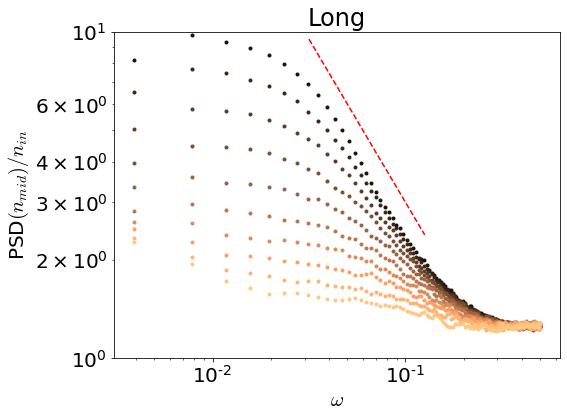

Working on ../200x1000


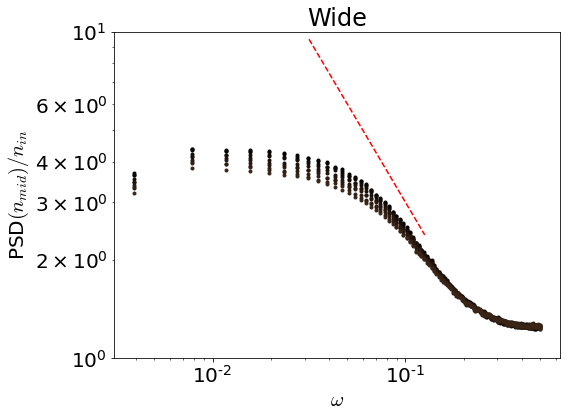

Working on ../Nys/q_50


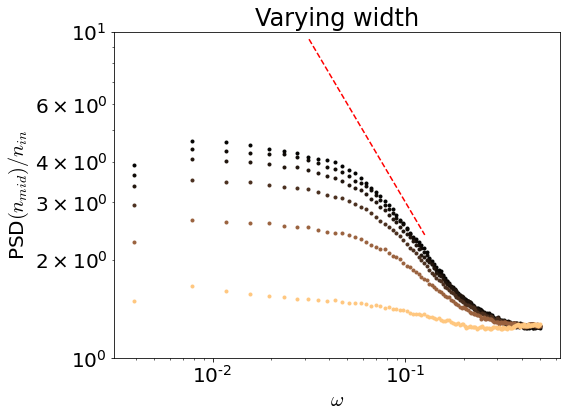

In [37]:
slopes_ba = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    plt.figure(figsize=(8,6))
    
    for ii,run in enumerate(runs_d[idir]):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]

        # Normalize
        rho = 1.25
        dx = 1#/(Nx-1)
        dt = 1#skipmax*dx / u_p
#         print('dt',dt)
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid#/q_in
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

        ## FFT
        freq, pds = sig.welch(q, 1/dt)#, nperseg=1024)
#         print(ps)

#         ps = np.abs(np.fft.fft(q))**2
#         freqs = np.fft.fftfreq(q.size, dt)
#         idx = np.argsort(freqs)
        
#         plt.figure(figsize=(8,6))

        plt.loglog(freq[:-1], pds[:-1]/q_in,
                 color = cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f, %sx%s" % (q8_in,Nx,Ny),lw=2,ls='',marker='.')


# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlim(3e-1,1/dt/2)
# plt.ylim(2,7e1)

    fplot2 = np.logspace(-1.5,-0.9)
    plt.plot(fplot2,0.3*fplot2**(-1),'--r')
#     fplot = np.logspace(np.log10(4),np.log10(20))
    # plt.plot(fplot,1e-2*fplot**(-2),'--r')
    # plt.plot(fplot,400*fplot**(-1.5),'--b')

    plt.xlabel(r"$\omega$")
    plt.title(leg[idir])#+r" $q^*_{in} =$ %.3f" % (q8_in))
    plt.ylabel(r"PSD$(n_{mid})/n_{in}$")
    #         plt.legend(loc=(1.01,0.0))
    plt.ylim(1,10)
    plt.show()

## PDFs

Working on ../1000x200
3.858104631322169 0.5382938177842711


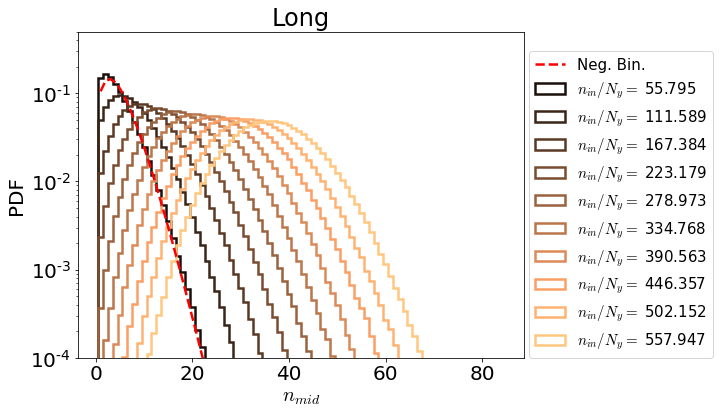

Working on ../200x1000
4.509684067080955 0.4846593530910519


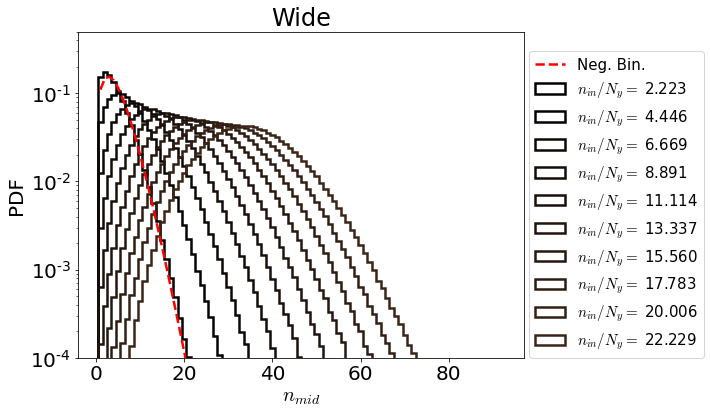

Working on ../Nys/q_50
9.955950822737647 0.6352082190724843


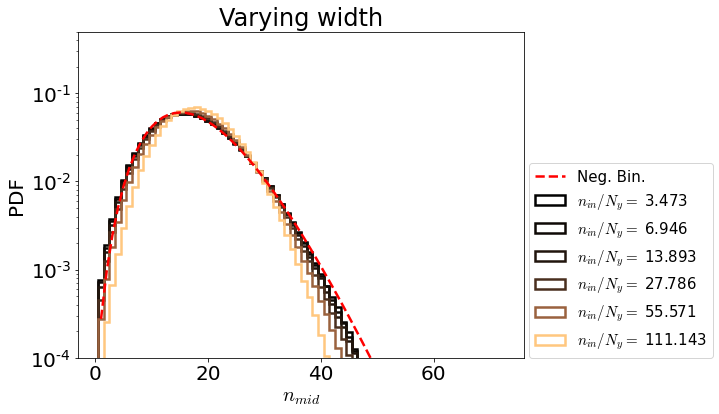

In [61]:
slopes_ba = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    plt.figure(figsize=(8,6))
    slopes_l = []
    q8s_l = []
    
    for ii,run in enumerate(runs_d[idir]):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]

        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$n_{in}/N_y =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])

        if ii==0:
            xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
            plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',lw=2.5,color = 'r',label="Neg. Bin.") 
#             xplt = np.linspace(np.min(q),np.max(q),1000)
#             plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = 'r',lw=2.5,label="Gamma.") 

    # ax=plt.gca()
    # ax.set_yscale('log')
    # plt.xlabel(r"$q_{out}$")
    plt.ylim(1e-4,.5)
    plt.xlabel(r"$n_{mid}$")
    plt.ylabel("PDF")
    plt.title(leg[idir])
    plt.legend(loc=(1.01,0.0),fontsize=15)#(1.01,0.0))
    plt.savefig('./Figures/PDF_e_1000x200.png',bbox_inches='tight',dpi=100)
    plt.show()  

Working on ../1000x200


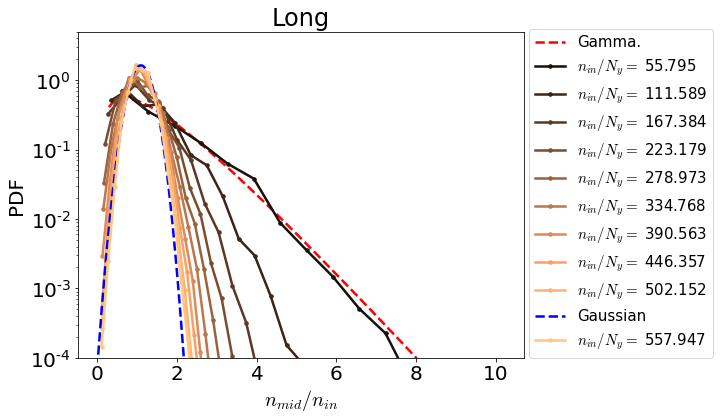

Working on ../200x1000


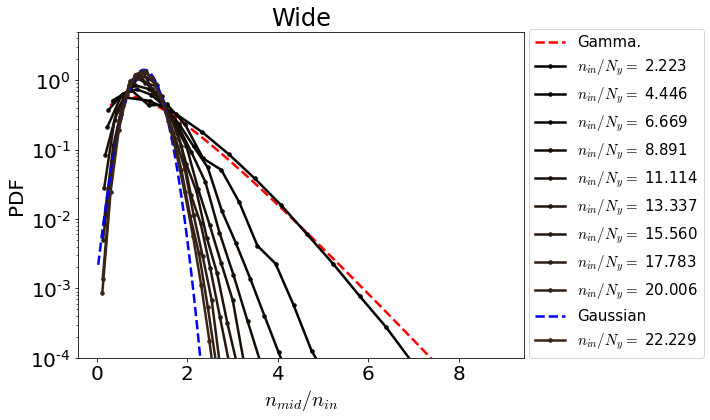

Working on ../Nys/q_50


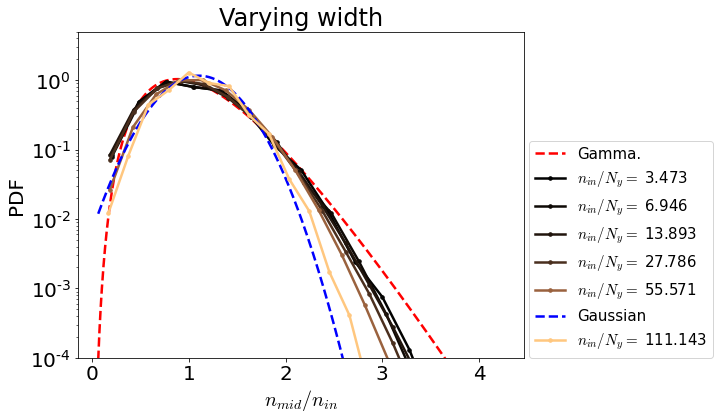

In [16]:
slopes_ba = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    plt.figure(figsize=(8,6))
    slopes_l = []
    q8s_l = []
    
    for ii,run in enumerate(runs_d[idir]):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]/(q_in/3.)
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
        if ii==0:
            xplt = np.linspace(np.min(q),np.max(q),1000)
            plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = 'r',lw=2.5,label="Gamma.") 
        elif ii==(len(runs_d[idir])-1):
            xplt = np.linspace(np.min(q),np.max(q),1000)
            plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'--',color = 'b',lw=2.5,label="Gaussian") 

        # Choose data to plot:
        nbins=15
        mindat=np.min(q)
        
        pdf, x_edges = np.histogram(q,bins=nbins,density=True)
        x = np.diff(x_edges)/2+x_edges[:-1]
        plt.semilogy(x[pdf>0],pdf[pdf>0],ls='-',marker='.',lw=2.5,ms=7, color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$n_{in}/N_y =$ %.3f" % (q8_in))#

        
    
    # ax=plt.gca()
    # ax.set_yscale('log')
    # plt.xlabel(r"$q_{out}$")
    plt.ylim(1e-4,5)
    plt.xlabel(r"$n_{mid}/n_{in}$")
    plt.ylabel("PDF")
    plt.title(leg[idir])
    plt.legend(loc=(1.01,0.0),fontsize=15)#(1.01,0.0))
    plt.show()  

Working on ../1000x200
3.858104631322169 0.5382938177842711


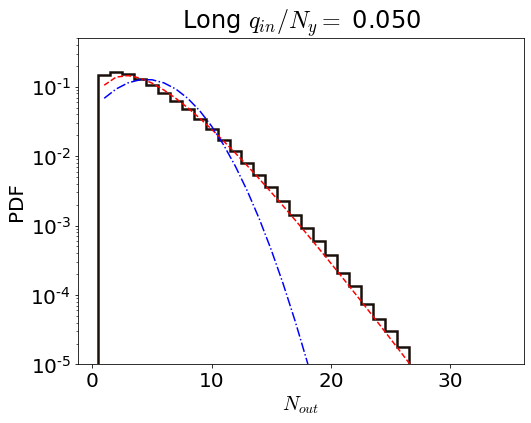

4.570101620304003 0.6161925079493932


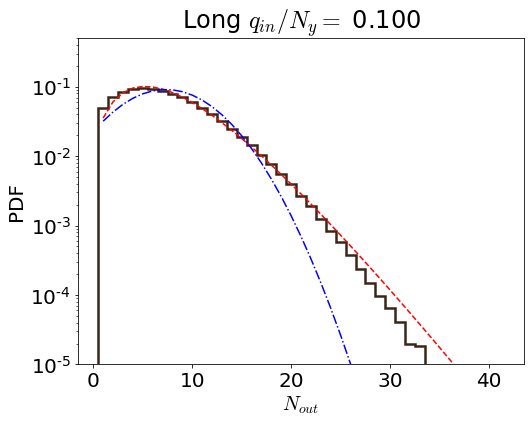

6.619132196686421 0.616624566875155


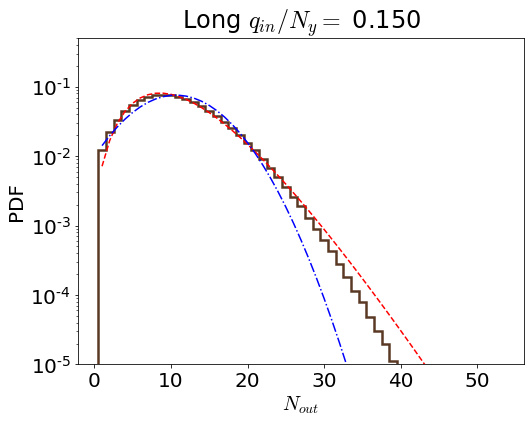

9.606345241436937 0.5961273782056112


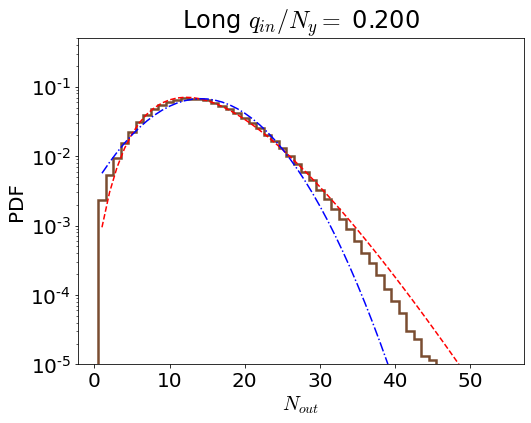

13.506073624738288 0.5682528574494218


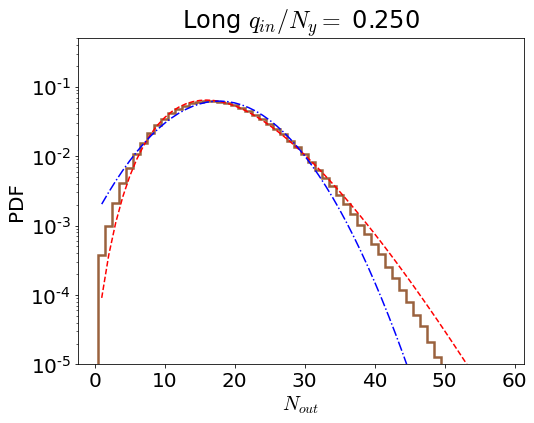

18.23376464738697 0.540825235705072


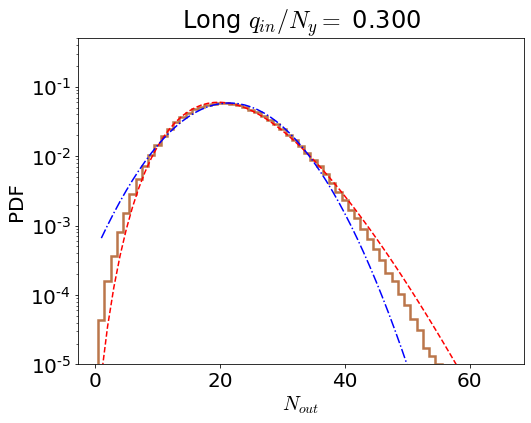

23.593726394381545 0.5161121999067292


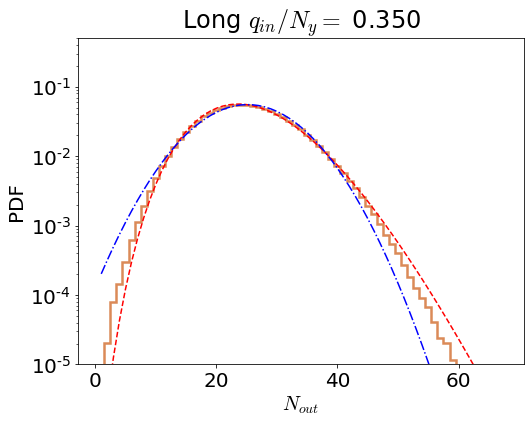

29.925270330561563 0.49248636632052006


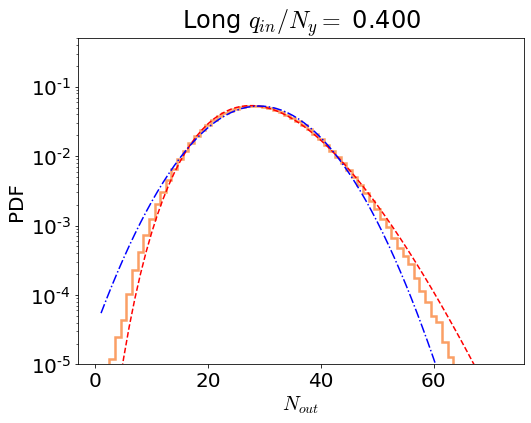

37.24800961460899 0.46793498119967275


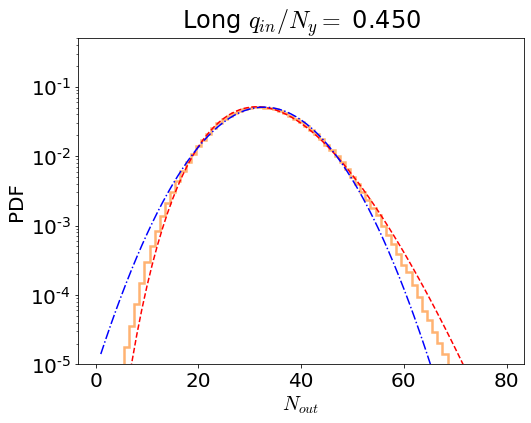

45.4439829417294 0.4464573052404336


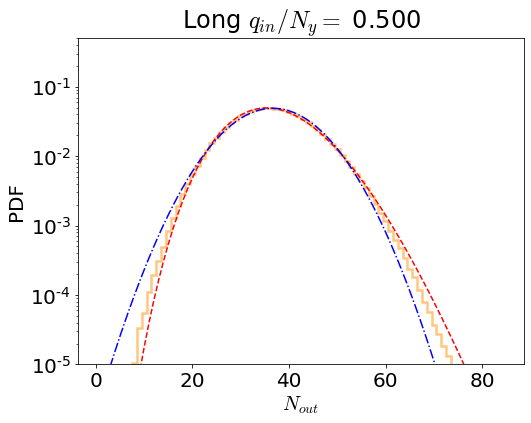

Working on ../200x1000
4.509684067080955 0.4846593530910519


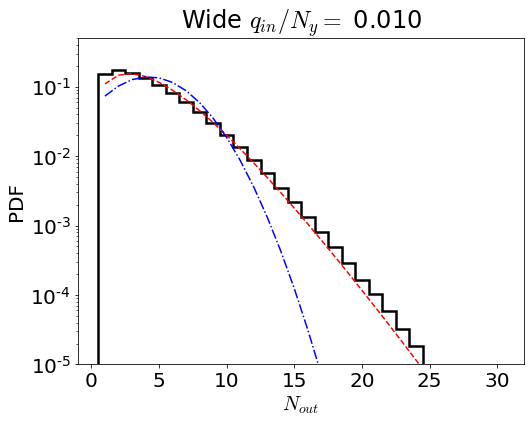

4.890438503483401 0.5950748446840523


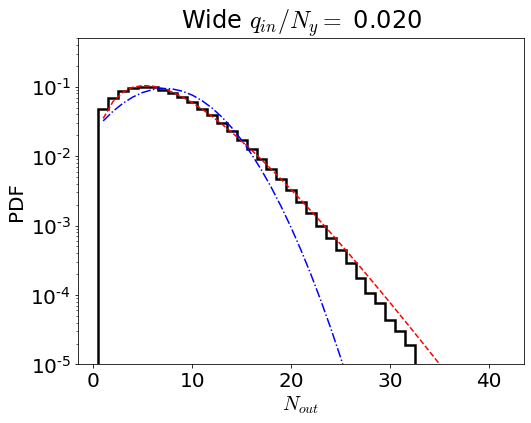

6.427025806379262 0.6200055875800576


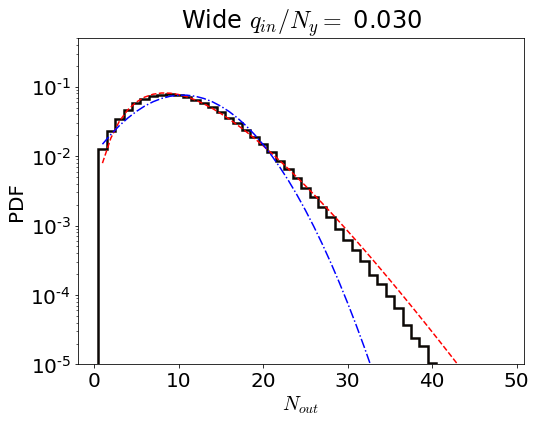

8.368602153084284 0.6244254150979733


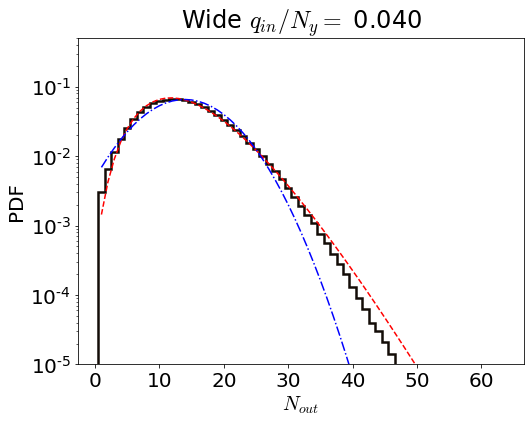

10.537449498852155 0.622719850969679


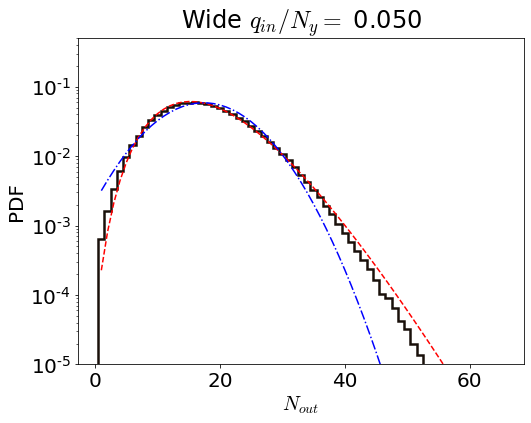

12.802860639962807 0.6200364317913856


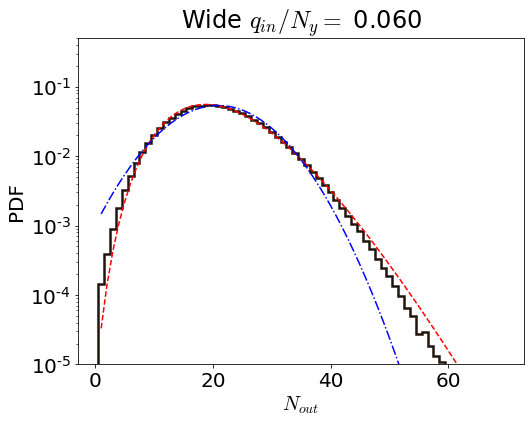

15.079786289949366 0.6180507804833111


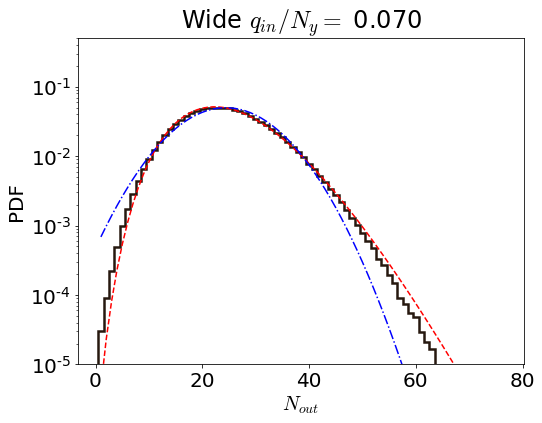

17.51755926847874 0.614332301192118


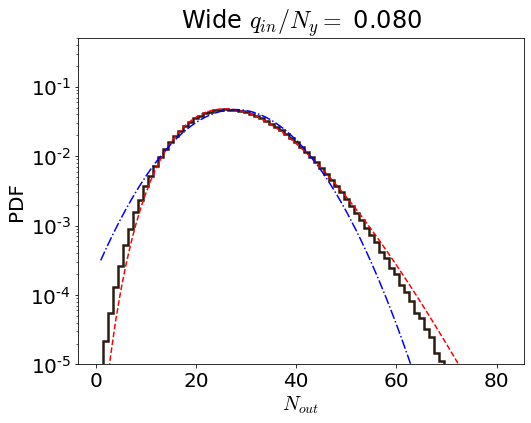

19.993646598078357 0.6111477048345577


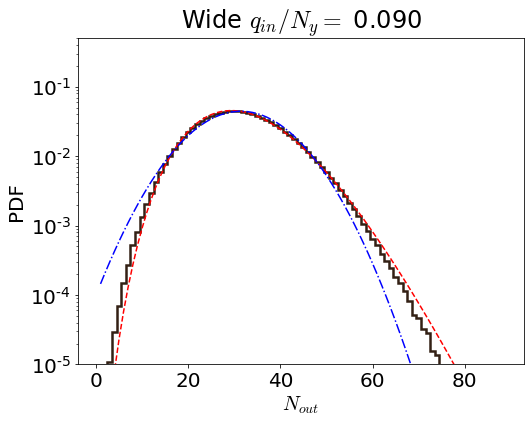

22.56733156227089 0.6075814580488357


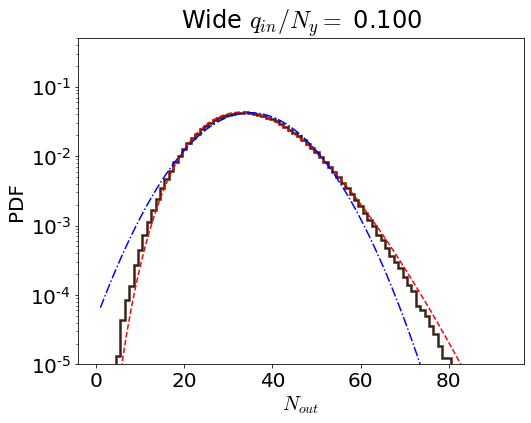

Working on ../Nys/q_50
9.955950822737647 0.6352082190724843


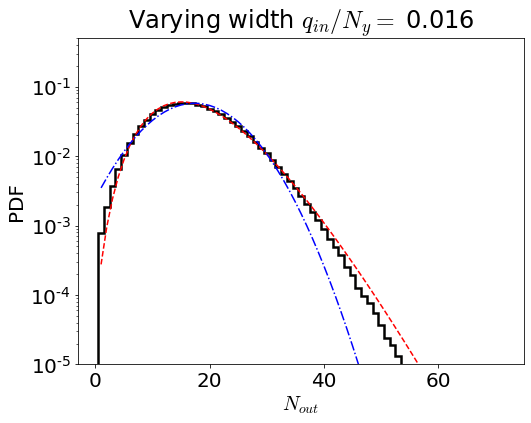

10.22495766068928 0.6293466892020594


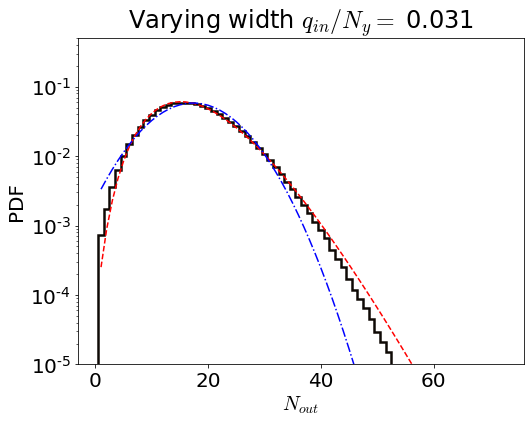

10.753181514737564 0.6183418434047252


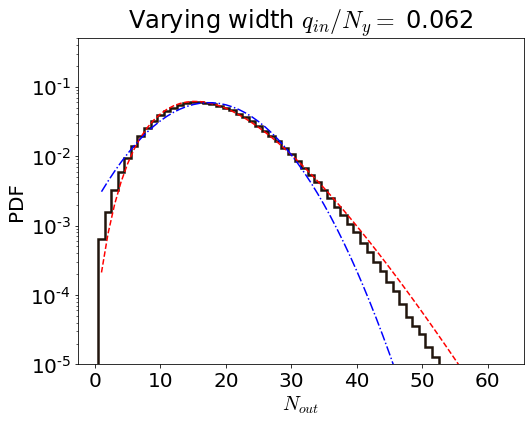

11.886986373165406 0.5957593445838166


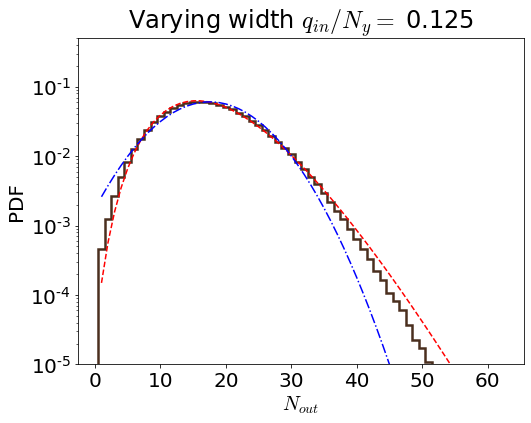

14.668997297047186 0.5477032190820551


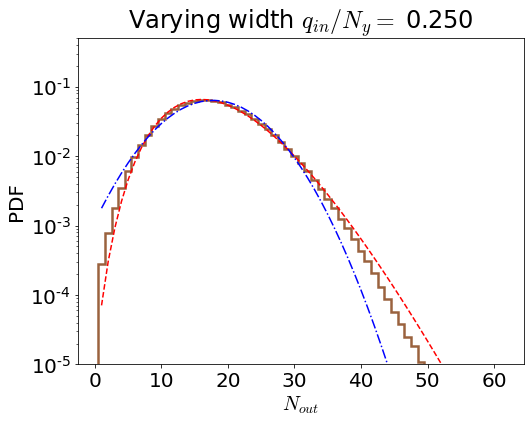

23.18656514453436 0.44187234611102977


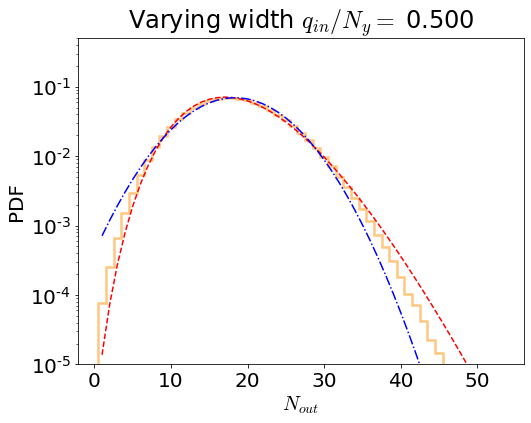

In [17]:
slopes_ba = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
#     plt.figure(figsize=(8,6))
    slopes_l = []
    q8s_l = []
    
    for ii,run in enumerate(runs_d[idir]):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q_mid = file['scalars']['e_mid'][()]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

        plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'-.',color = 'b')
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

        # ax=plt.gca()
        # ax.set_yscale('log')
        # plt.xlabel(r"$q_{out}$")
        plt.ylim(1e-5,0.5)
        plt.xlabel(r"$N_{out}$")
        plt.ylabel("PDF")
        plt.title(leg[idir]+r" $q_{in}/N_y =$ %.3f" % (q_in/Ny))
#         plt.legend(loc=(1.01,0.0))
        plt.show()
        plt.close()  

# Profiles

Working on ../1000x200
Working on q_1d000000e+01
Working on q_2d000000e+01
Working on q_3d000000e+01
Working on q_4d000000e+01
Working on q_5d000000e+01
Working on q_6d000000e+01
Working on q_7d000000e+01
Working on q_8d000000e+01
Working on q_9d000000e+01
Working on q_1d000000e+02


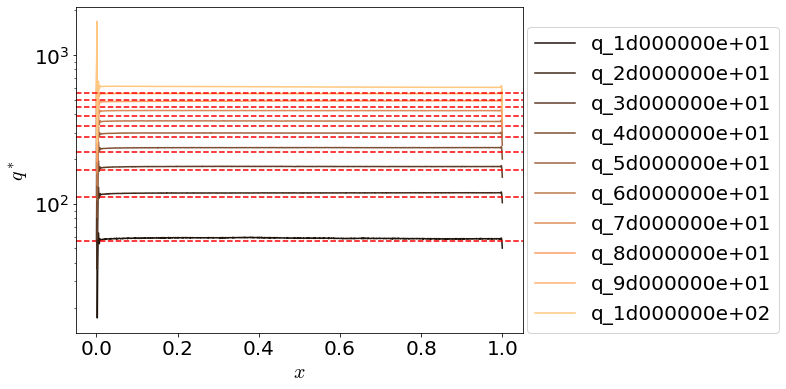

Working on ../200x1000
Working on q_1d000000e+01
Working on q_2d000000e+01
Working on q_3d000000e+01
Working on q_4d000000e+01
Working on q_5d000000e+01
Working on q_6d000000e+01
Working on q_7d000000e+01
Working on q_8d000000e+01
Working on q_9d000000e+01
Working on q_1d000000e+02


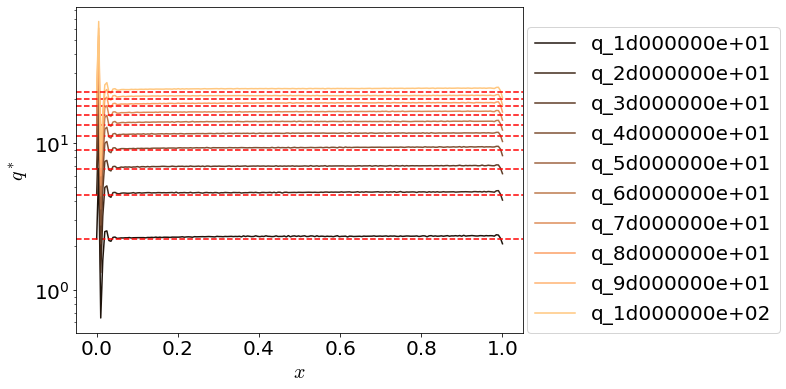

In [24]:
for idir in idirs:
    plt.figure(figsize=(8,6))
    print("Working on %s" % idir)
    for run in runs:
        print("Working on %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]
        # Initialize
        set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)
    #     norm = set_q.dt**-1 * (4/3.) * np.pi * 1/float(Ny) * set_q.rho
        q8_in = q_in/set_q.norm

        # Close file:
        file.close()

        if idir == '../200x1000':
            qmean = np.loadtxt(idir+'_profs/'+run+'/mean_q.txt')
            qvar = np.loadtxt(idir+'_profs/'+run+'/var_q.txt')
            x = np.loadtxt(idir+'_profs/'+run+'/x.txt')
        else:
            qmean = np.loadtxt(idir+'/'+run+'/mean_q.txt')
            qvar = np.loadtxt(idir+'/'+run+'/var_q.txt')
            x = np.loadtxt(idir+'/'+run+'/x.txt')
        plt.semilogy(x,qmean,label=run,c=cm.copper(q_in/100))
        plt.axhline(y=q8_in,c='r',ls='--')

    plt.xlabel(r"$x$")
    plt.ylabel(r"$q^*$")
    plt.legend(loc=(1.01,0.0))
    plt.show()

Working on ../1000x200


<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  pl

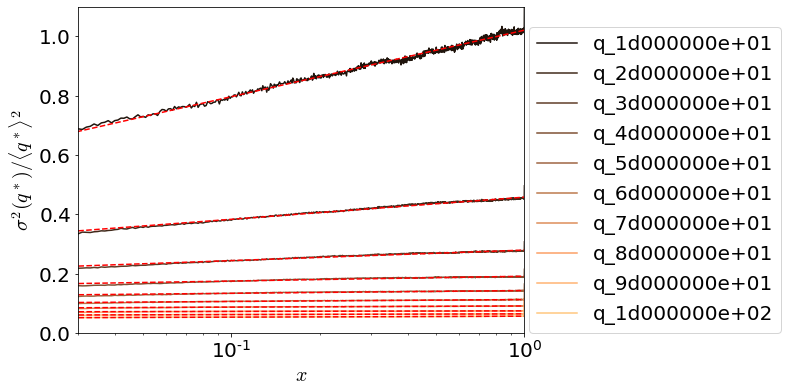

Working on ../200x1000


<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(xplt,b+m*np.log(xplt),'--r')
<ipython-input-31-1ed0794437a6>:37: RuntimeWarning: divide by zero encountered in log
  pl

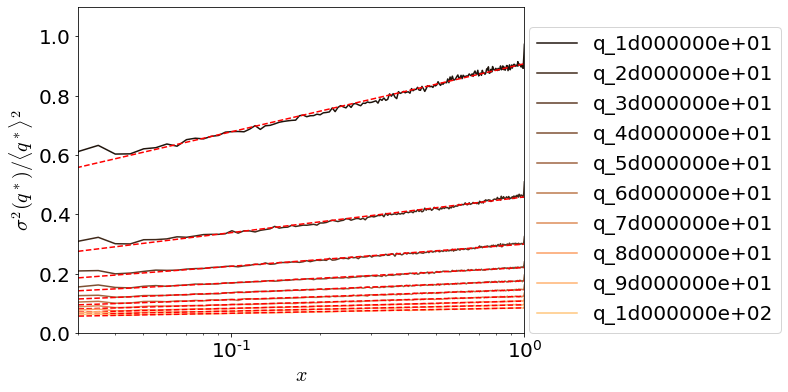

In [31]:
for idir in idirs:
    plt.figure(figsize=(8,6))
    print("Working on %s" % idir)
    for run in runs:
#         print("Working on %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]
        # Initialize
        set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)
    #     norm = set_q.dt**-1 * (4/3.) * np.pi * 1/float(Ny) * set_q.rho
        q8_in = q_in/set_q.norm

        # Close file:
        file.close()
    
        if idir == '../200x1000':
            qmean = np.loadtxt(idir+'_profs/'+run+'/mean_q.txt')
            qvar = np.loadtxt(idir+'_profs/'+run+'/var_q.txt')
            x = np.loadtxt(idir+'_profs/'+run+'/x.txt')
        else:
            qmean = np.loadtxt(idir+'/'+run+'/mean_q.txt')
            qvar = np.loadtxt(idir+'/'+run+'/var_q.txt')
            x = np.loadtxt(idir+'/'+run+'/x.txt')
        plt.semilogx(x,qvar/qmean**2,label=run,c=cm.copper(q_in/100))
    #     plt.axhline(y=q8_in,c='r',ls='--')
        m,b = np.polyfit(np.log(x[x>3e-2]),qvar[x>3e-2]/qmean[x>3e-2]**2,1)
#         print(m)
        xplt = np.linspace(0,1,1000)
        plt.semilogx(xplt,b+m*np.log(xplt),'--r')

    plt.xlabel(r"$x$")
    plt.ylabel(r"$\sigma^2(q^*)/\langle q^* \rangle^2$",fontsize=20)
    plt.legend(loc=(1.01,0.0))
    plt.ylim(0,1.1)
    plt.xlim(3e-2,1)
    plt.show()

# Time series

## $q^*_{mid}$

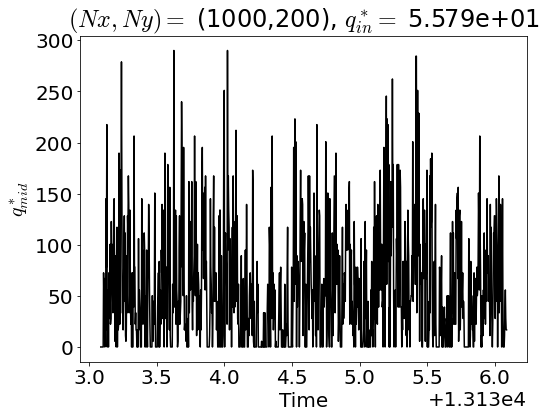

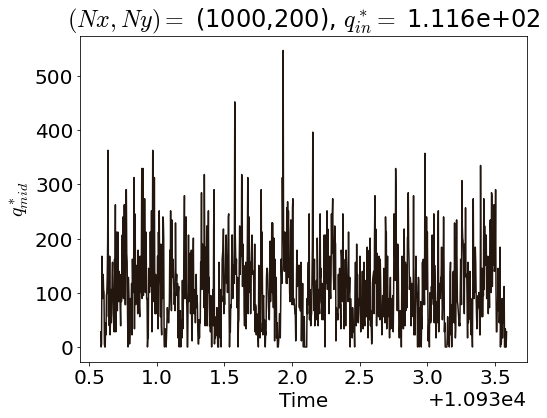

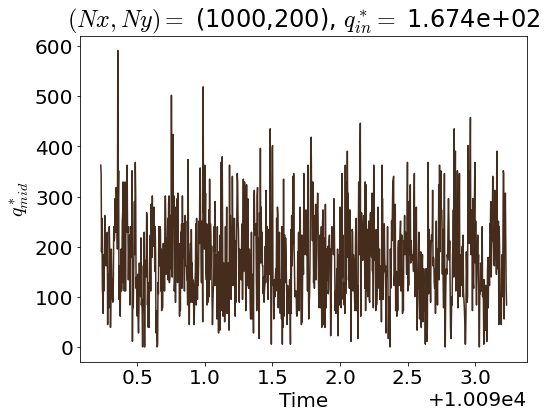

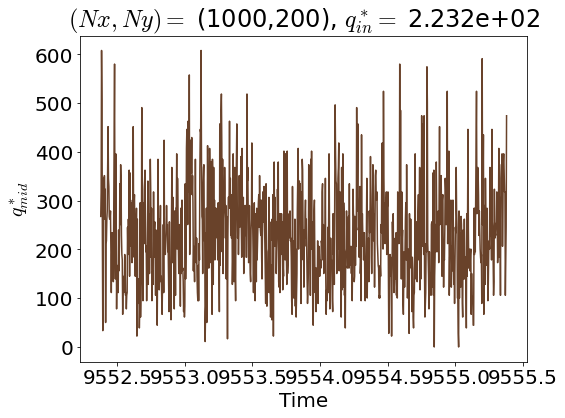

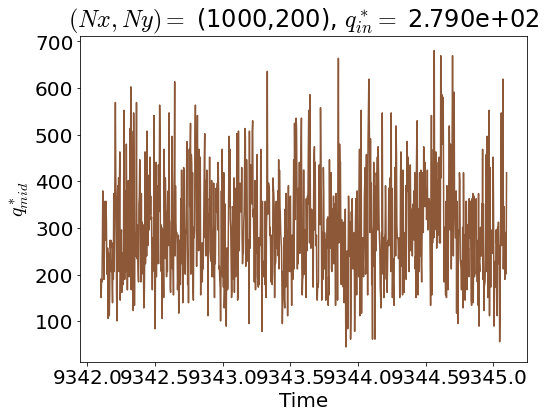

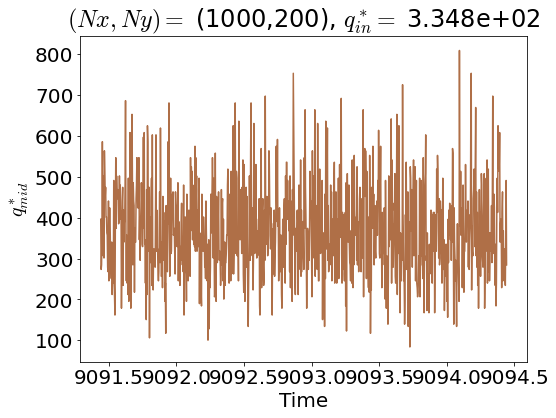

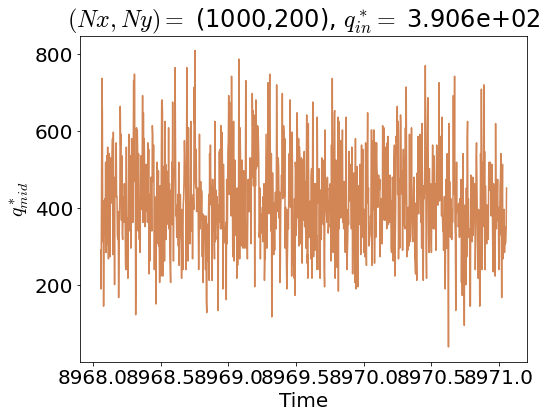

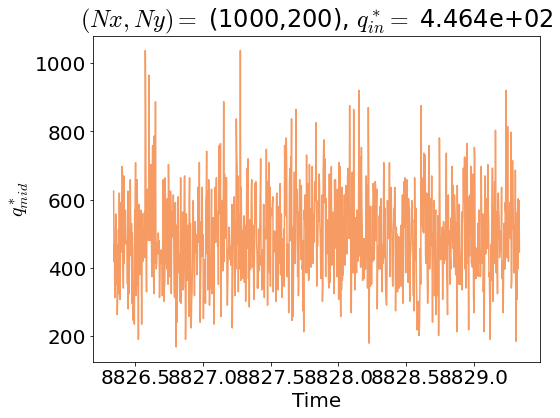

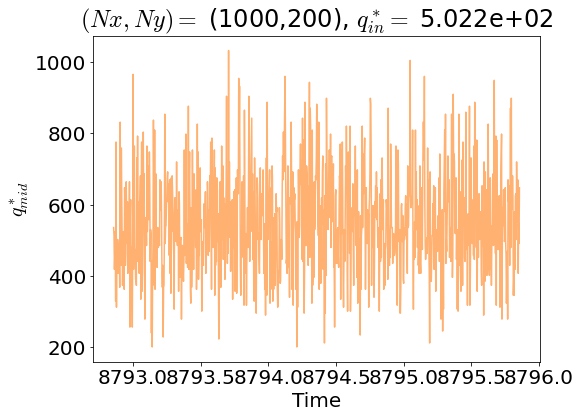

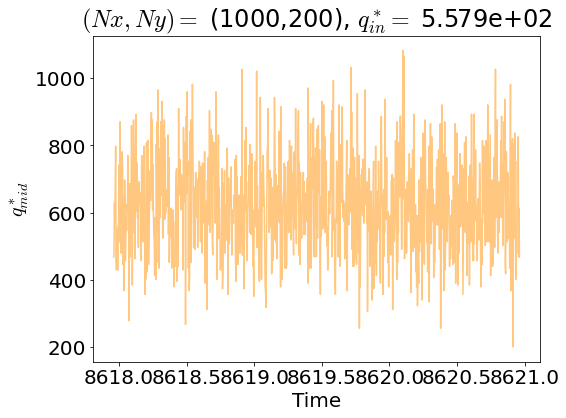

In [57]:
# idir = '../128x128'
idir = '../1000x200'
# run = 'q_1d000000e+01'
for run in runs:
    #         print("Working on run %s" % run)
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')

    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    u_p = file['parameters']['u_p'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

    # Normalize
    rho = 1.25
    dx = 1/(Nx-1)
    dt = skipmax*dx / u_p
    norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
    q8_in = q_in_real/norm

    # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
    time = file['scalars']['time'][()][300:]
    #         tstep = file['scalars']['tstep'][()]
    q_mid = file['scalars']['q_mid'][()][300:]
    #         q8_mid = q_mid*norm

    # Close file:
    file.close()

    plt.figure(figsize=(8,6))
    plt.plot(time[:1000],q_mid[:1000],color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)))
    plt.xlabel("Time")
    plt.ylabel("$q^*_{mid}$")
    plt.title(r'$(Nx,Ny) =$ (%s,%s), $q^*_{in} = $ %.3e' % (Nx,Ny,q8_in))
    plt.show()

## Time series PDFs

Working on ../1000x200
Working on ../200x1000


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Working on ../Nys/q_50


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


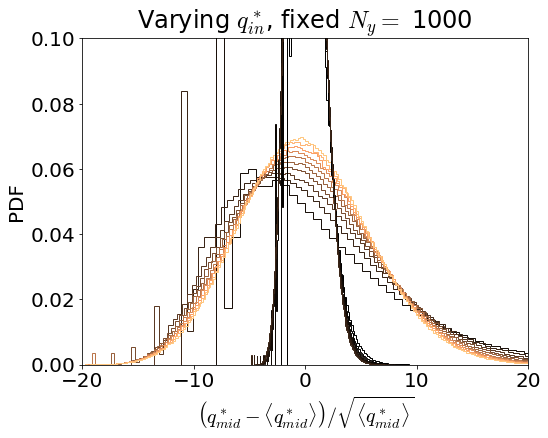

In [12]:
slopes_ba = dict([])
qin_reals_ba = dict([])
    
for idir in idirs:
    plt.figure(figsize=(8,6))

    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    for ii,run in enumerate(runs_d[idir]):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = 1#skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid
        q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=False,density=True,color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


    slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

plt.ylim(0,0.1)
plt.xlim(-20,20)
plt.xlabel(r"$\left(q^*_{mid}-\langle q^*_{mid}\rangle\right) / \sqrt{\langle q^*_{mid} \rangle }$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ %s" % Ny)
plt.show()
plt.close()  

Working on ../1000x200


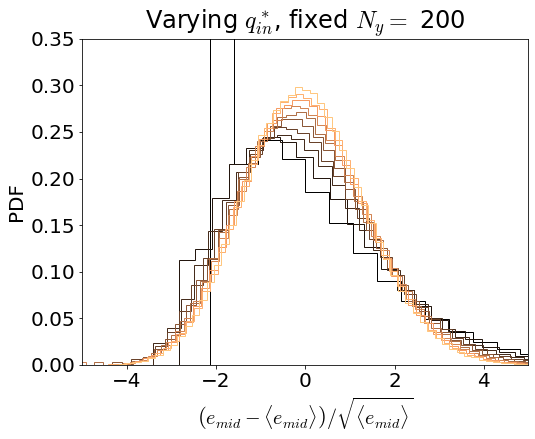

In [62]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid
        q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=False,density=True,color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


    slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

plt.ylim(0,0.35)
plt.xlim(-5,5)
plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ %s" % Ny)
plt.show()
plt.close()  

Working on ../1000x200
46.015296343378026 0.4452379577839433


<Figure size 576x432 with 0 Axes>

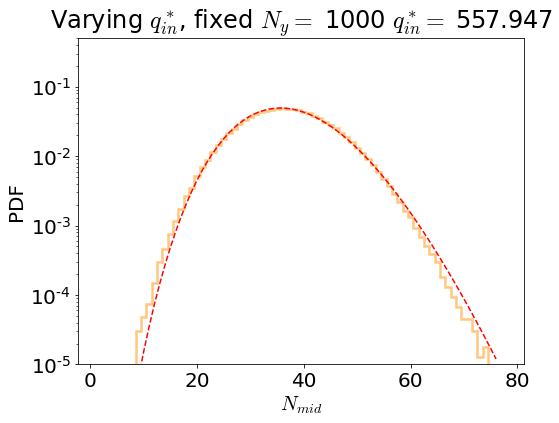

37.3627164613479 0.46730553810813247


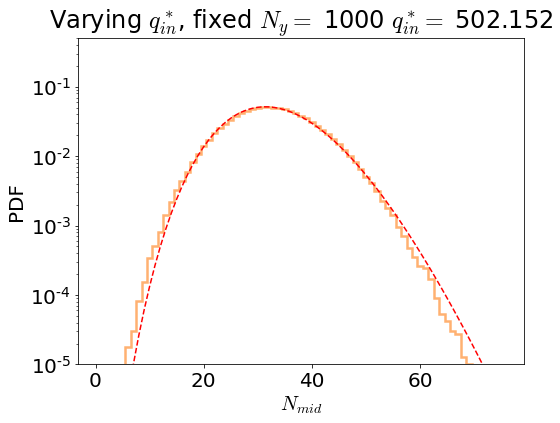

30.26499637276168 0.49024836296237045


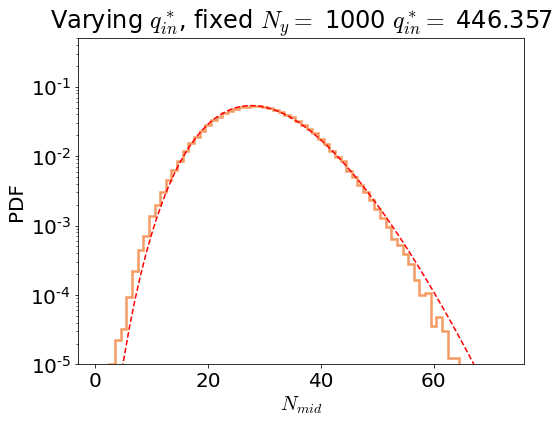

23.509310910381537 0.516994232606448


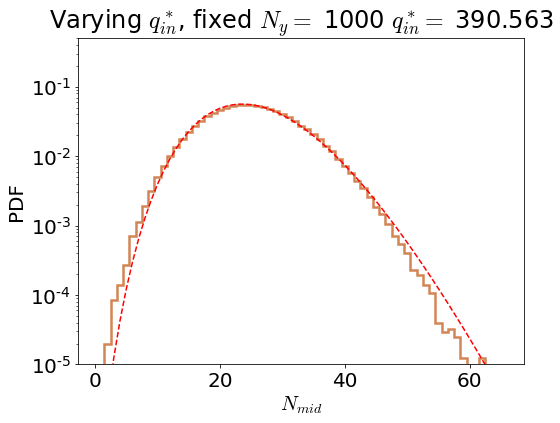

18.28795125771013 0.5401178925328262


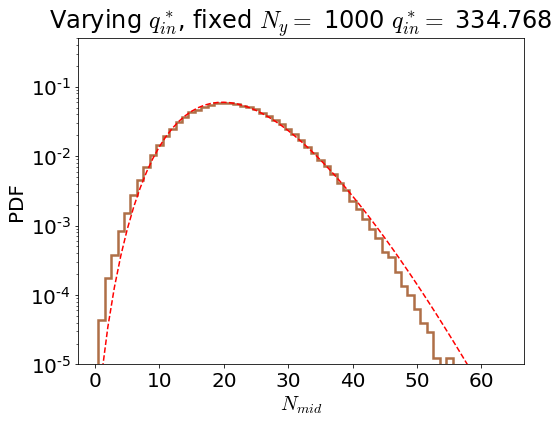

13.53215893017881 0.5681216763618955


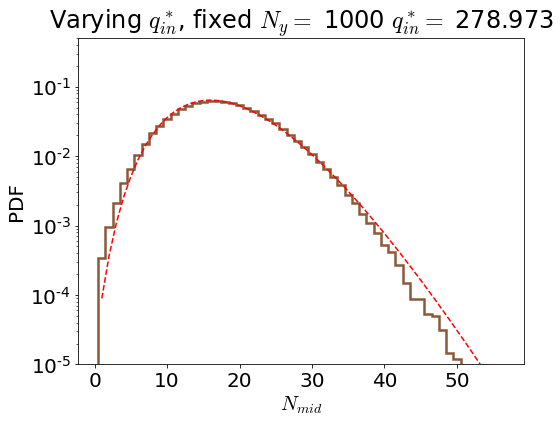

9.587224104926754 0.596722298634855


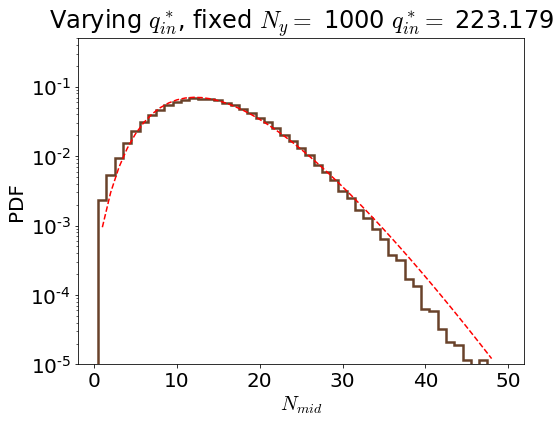

6.641017238538456 0.6159337767283377


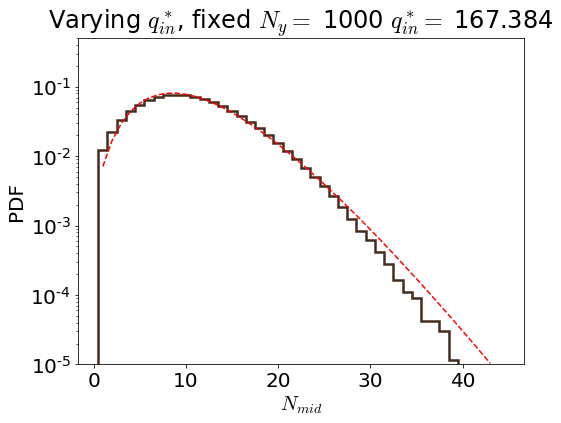

4.570304000571598 0.6161679059561715


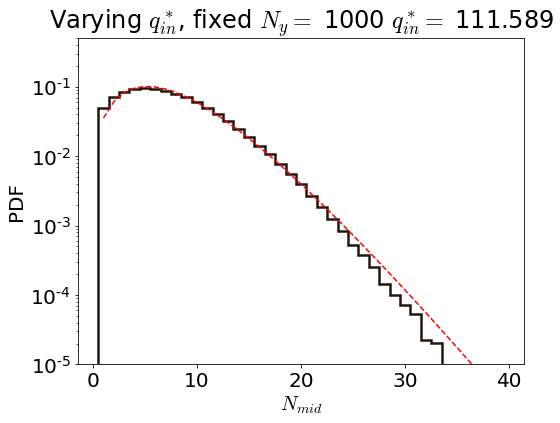

3.8488538373426877 0.5385031818199444


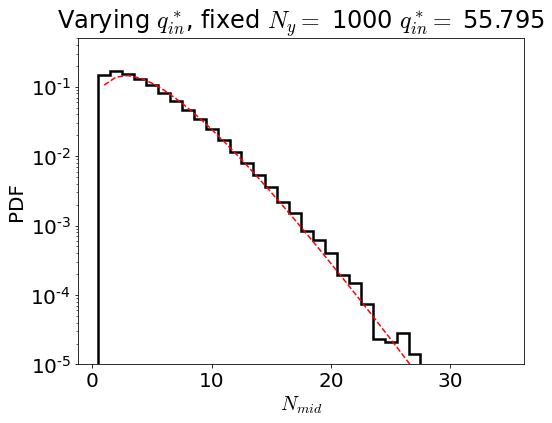

In [92]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
#         q_mid = file['scalars']['q_out'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

        plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

        # ax=plt.gca()
        # ax.set_yscale('log')
        # plt.xlabel(r"$q_{out}$")
        plt.ylim(1e-5,0.5)
        plt.xlabel(r"$N_{mid}$")
        plt.ylabel("PDF")
        plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000"+r" $q^*_{in} =$ %.3f" % (q8_in))
#         plt.legend(loc=(1.01,0.0))
        plt.show()
        plt.close()  

Working on ../1000x200


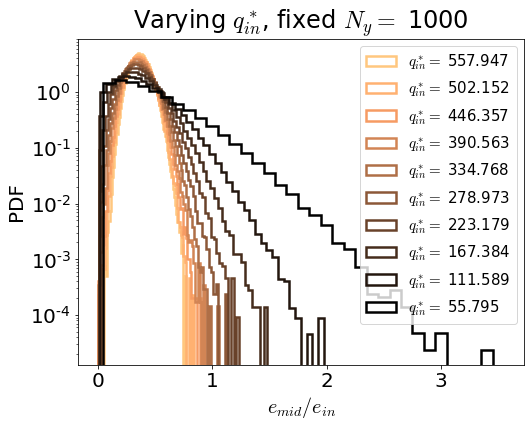

In [73]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]/q_in_real
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]

        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])

        if q_in_real/Ny==0.01:
#             xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#             plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',lw=2.5,color = 'r',label="Neg. Bin.") 
            xplt = np.linspace(np.min(q),np.max(q),1000)
            plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = 'r',lw=2.5,label="Gamma.") 

# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlabel(r"$q_{out}$")
# plt.ylim(1e-4,5)
plt.xlabel(r"$e_{mid}/e_{in}$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")
plt.legend(loc=1,fontsize=15)#(1.01,0.0))
plt.savefig('./Figures/PDF_enormed_1000x200.png',bbox_inches='tight',dpi=100)
plt.show()  

Working on ../1000x200


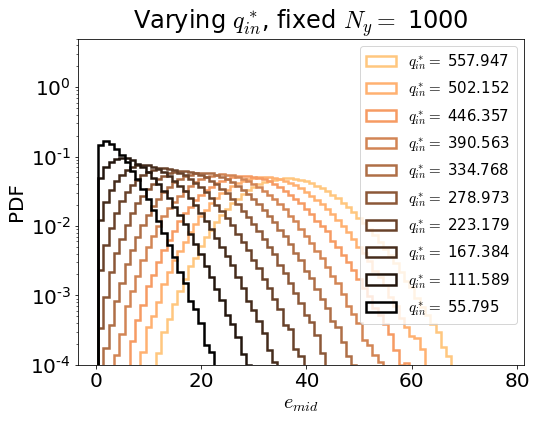

In [74]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]

        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])

        if q_in_real/Ny==0.01:
            xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
            plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',lw=2.5,color = 'r',label="Neg. Bin.") 
#             xplt = np.linspace(np.min(q),np.max(q),1000)
#             plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = 'r',lw=2.5,label="Gamma.") 

# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlabel(r"$q_{out}$")
plt.ylim(1e-4,5)
plt.xlabel(r"$e_{mid}$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")
plt.legend(loc=1,fontsize=15)#(1.01,0.0))
plt.savefig('./Figures/PDF_e_1000x200.png',bbox_inches='tight',dpi=100)
plt.show()  

Working on ../1000x200


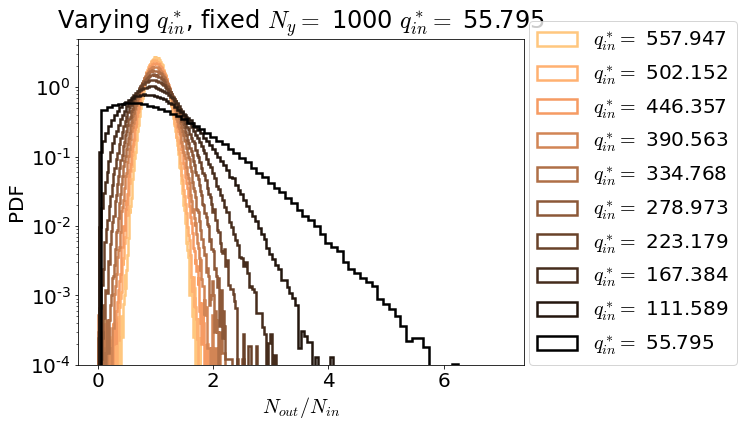

In [75]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_out'][()][300:]/q_in
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
#         xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
# #         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
#         plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
#         plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'-.',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlabel(r"$q_{out}$")
plt.ylim(1e-4,5)
plt.xlabel(r"$N_{out}/N_{in}$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000"+r" $q^*_{in} =$ %.3f" % (q8_in))
plt.legend(loc=(1.01,0.0))
plt.show()
plt.close()  

Working on ../1000x200


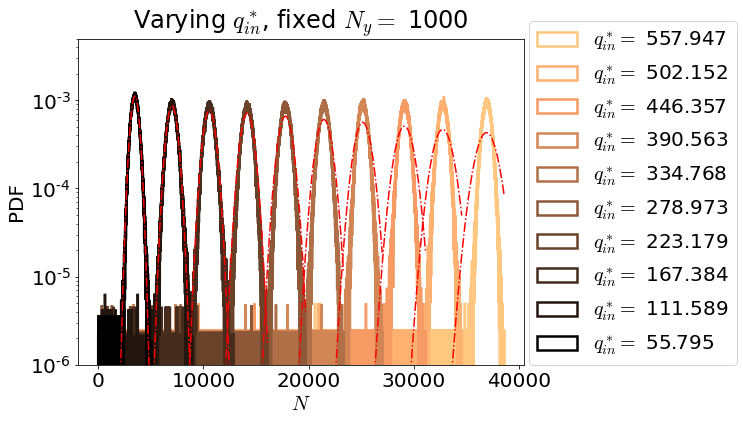

In [76]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['bed_activity'][()][300:]*Ny*Nx
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
#         plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'-.',color = 'r')
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlabel(r"$q_{out}$")
plt.ylim(1e-6,5e-3)
plt.xlabel(r"$N$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")
plt.legend(loc=(1.01,0.0))
plt.show()
plt.close()  

## Waiting time PDF

ValueError: zero-size array to reduction operation maximum which has no identity

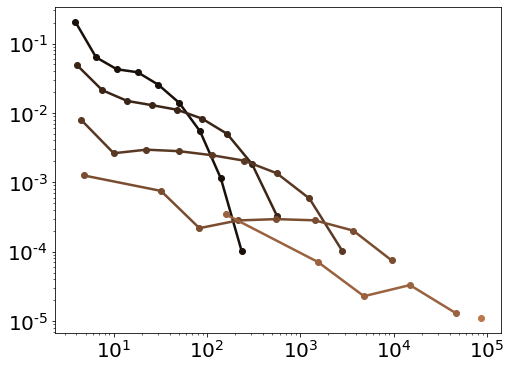

In [23]:
slopes_ba = dict([])
qin_reals_ba = dict([])

for idir in idirs:
    for thresh_m in [
        1,
        2,
        4,
    #     30,
    #     40,
    #     100,
    ]:
        qm = []
        qs = []
        slopes_wt = []
        q8_ins_wt = []
        # maxdat = 1.0

        nbins = 10

        plt.figure(figsize=(8,6))

        for ii,run in enumerate(runs_d[idir]):
            # Open 
            fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
            file = h5py.File(fname,'r')

            # Get parameters:
            Nx = file['parameters']['Nx'][()]
            Ny = file['parameters']['Ny'][()]
            c_0 = file['parameters']['c_0'][()]
            f = file['parameters']['f'][()]
            u_p = file['parameters']['u_p'][()]
            q_in = file['parameters']['q_in'][()]
            skipmax = file['parameters']['skipmax'][()]

            thresh = thresh_m*q_in
            
            # Normalize
            rho = 1.25
            dx = 1/(Nx-1)
            dt = 1#skipmax*dx / u_p 
            mindat = 3*dt
            norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
            q8_in = q_in/norm

            # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
            q = file['scalars']['e_mid'][()] # So that it's number of grains * vel

            # Close file:
            file.close()

            ##############################

            # Choose data to plot:
            dat = onoff_dist(q,dt,thresh)
            hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
            x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
            y = hist
        #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

            # Plot
        #     plt.figure(figsize=(8,6))
            plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)][:-1]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)][:-1])-x[(x>np.log10(mindat))&(y>0)][:-1]),ls='-',marker='o',label='',
                       color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),lw=2.5)
        #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
        #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

        #     plt.axvline(x=int(1/q_in),color = 'b')

        #     # Finite size effect cutoff
        #     nbeads = 2# Number of grains considered 'too small'
        #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
        #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
        #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

        #     # Fit
        #     fitmax = 2e-3
        #     fitmin = xcutoff 
        #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
        #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
        #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
        #     slopes_ba.append(m)
        #     q8_ins_ba.append(q8_in)

        m = -3/2.
        b = 1.
        xpl = np.logspace(np.log10(mindat),np.log10(50),100)
        plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

        plt.legend()#loc=(1.01,0.0))
        plt.title("%s $N_{mid}$ threshold = %s $\times n_{in}$" % (leg[idir],thresh))
        plt.xlabel(r"Waiting Time (dimensionless)")
        # plt.xlabel(r"$q_{out}$")

        plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

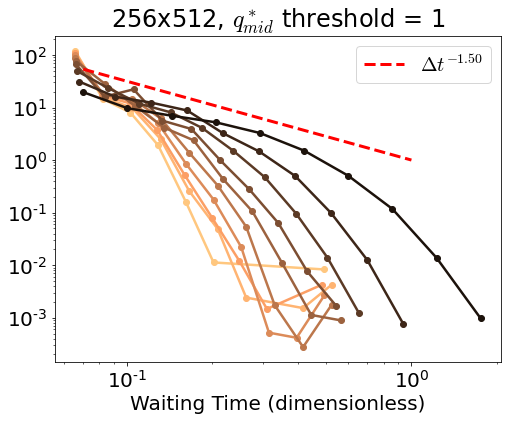

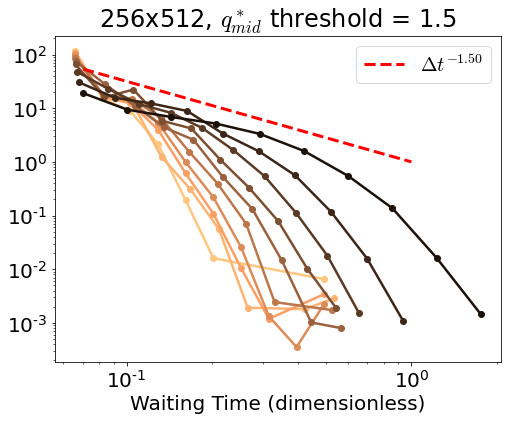

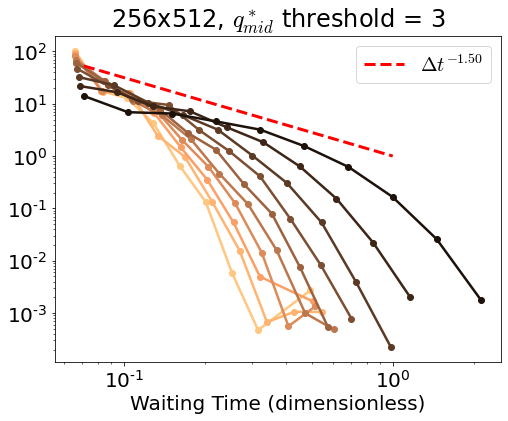

In [33]:
# Choose directory
# idir = '../200x40/'
Nx = 256
Ny = 512
idir = '../'+str(Nx)+'x'+str(Ny)+'/'
u_p = 1
skipmax=3
dx = 1/(Nx-1)

dt = skipmax*dx / u_p

exp_plot= [
    'q_1d000000e+00',
    'q_2d000000e+00',
    'q_3d000000e+00',
    'q_4d000000e+00',
    'q_5d000000e+00',
    'q_6d000000e+00',
    'q_7d000000e+00',
    'q_8d000000e+00',
    'q_9d000000e+00',
    'q_1d000000e+01',
]

for thresh in [
    1,
    1.5,
    3,
#     30,
#     40,
#     100,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    mindat = 5*dt
    # maxdat = 1.0

    nbins = 10

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        q = file['scalars']['q_mid'][()] # So that it's number of grains * vel
        
        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dat = onoff_dist(q,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(1),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, $q^*_{mid}$ threshold = %s" % (Nx,Ny,thresh))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

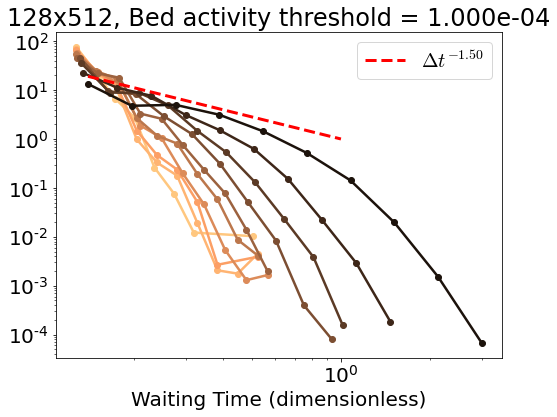

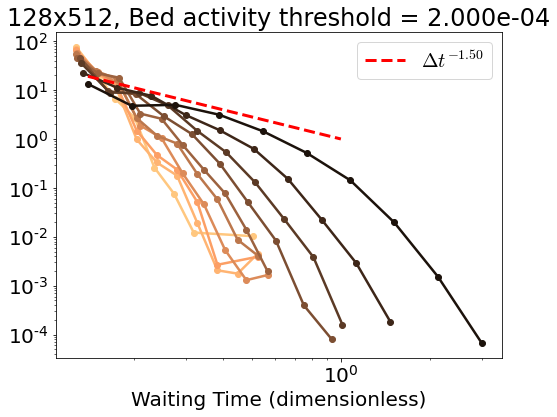

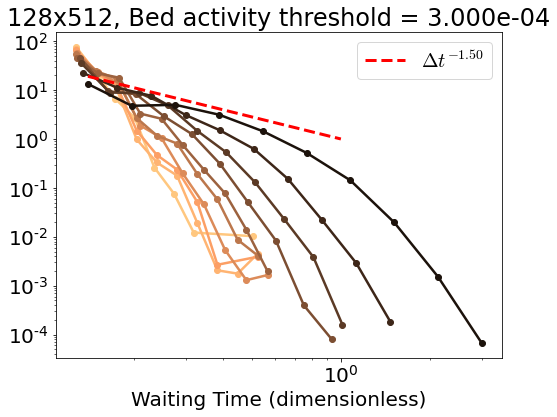

In [104]:
# Choose directory
# idir = '../200x40/'
Nx = 128
Ny = 512
idir = '../'+str(Nx)+'x'+str(Ny)+'/'
u_p = 1
skipmax=3
dx = 1/(Nx-1)

dt = skipmax*dx / u_p

exp_plot= [
    'q_1d000000e+00',
    'q_2d000000e+00',
    'q_3d000000e+00',
    'q_4d000000e+00',
    'q_5d000000e+00',
    'q_6d000000e+00',
    'q_7d000000e+00',
    'q_8d000000e+00',
    'q_9d000000e+00',
    'q_1d000000e+01',
]

for thresh in [
    1,
    2,
    3,
#     30,
#     40,
#     100,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    mindat = 5*dt
    # maxdat = 1.0

    nbins = 10
    
    thresh = thresh*10**(-4)

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        q = file['scalars']['q_mid'][()] # So that it's number of grains * vel
        
        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dat = onoff_dist(q,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(1),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, Bed activity threshold = %.3e" % (Nx,Ny,thresh))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

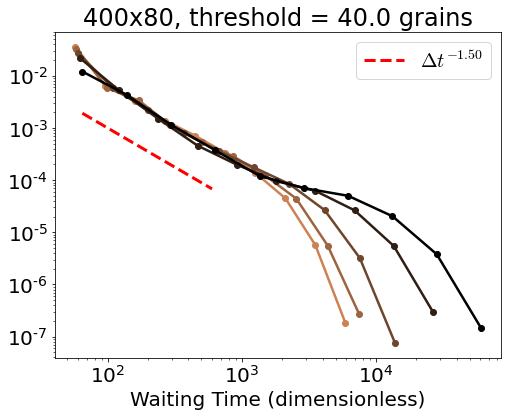

In [38]:
# Choose directory
idir = '../400x80/'
Nx = 400
Ny = 80

exp_plot= [
#     'q_1d000000e-02', # These don't exist yet
#     'q_1d513561e-02', # These don't exist yet
#     'q_2d290868e-02', # These don't exist yet
#     'q_3d467369e-02', # These don't exist yet
#     'q_5d248075e-02', # These don't exist yet
#     'q_7d943282e-02', # These don't exist yet
    'q_1d000000e-01', 
#     'q_1d359356e-01', 
    'q_1d847850e-01', 
#     'q_2d511886e-01', 
    'q_3d414549e-01', 
#     'q_4d641589e-01', 
    'q_6d309573e-01', 
#     'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
    'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
#     'q_1d000000e+01',
]

for thresh in [
#     10,
#     20,
    40,
#     80,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    dt_min = 5e-3
    dt_max = 5
    pdf_min = 1e-3
    pdf_max = 5e2

    dt = 22.139999985694885 # Simulation parameter

    mindat = 2*dt
    # maxdat = 1.0

    nbins = 10

    thresh = thresh/(Nx*Ny)#20/(Nx*Ny)#10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        rho = 0.8
        dt = file['parameters']['dt'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
        q8_in = norm*q_in_real

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        time = file['scalars']['time'][()]
        tstep = file['scalars']['tstep'][()]
        q_out = file['scalars']['q_out'][()]
        q8_out = q_out*norm
        bed_activity = file['scalars']['bed_activity'][()]

        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dt = np.diff(time)[0]
        dat = onoff_dist(bed_activity,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(600),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

In [23]:
# # Choose directory
# idir = '../400x80/'
# Nx = 400
# Ny = 80

# exp_plot= [
# #     'q_1d000000e-02',  #
# #     'q_1d513561e-02',  #
# #     'q_2d290868e-02',  # These runs don't exist yet
# #     'q_3d467369e-02',  # 
# #     'q_5d248075e-02',  #
# #     'q_7d943282e-02',  #
#     'q_1d000000e-01', 
# #     'q_1d359356e-01', 
#     'q_1d847850e-01', 
# #     'q_2d511886e-01', 
#     'q_3d414549e-01', 
# #     'q_4d641589e-01', 
#     'q_6d309573e-01', 
# #     'q_8d576959e-01', 
# #     'q_1d165914e+00', 
# #     'q_1d584893e+00', 
#     'q_2d154435e+00', 
# #     'q_2d928645e+00', 
# #     'q_3d981072e+00', 
# #     'q_5d411695e+00', 
# #     'q_7d356423e+00', 
# #     'q_1d000000e+01',
# ]

# qm = []
# qs = []
# slopes_wt = []
# q8_ins_wt = []

# dt_min = 5e-3
# dt_max = 5
# pdf_min = 1e-3
# pdf_max = 5e2

# dt = 22.139999985694885 # Simulation parameter

# mindat = 2*dt
# # maxdat = 1.0

# nbin = 15

# thresh = 10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

# plt.figure(figsize=(8,6))

# for ii,run in enumerate(exp_plot):
#     # Open 
#     fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
#     file = h5py.File(fname,'r')
    
#     # Get parameters:
#     Nx = file['parameters']['Nx'][()]
#     Ny = file['parameters']['Ny'][()]
#     c_0 = file['parameters']['c_0'][()]
#     f = file['parameters']['f'][()]
#     q_in = file['parameters']['q_in'][()]
#     skipmax = file['parameters']['skipmax'][()]
#     rho = 0.8
#     dt = file['parameters']['dt'][()]
#     if q_in<1:
#         q_in_real = 1/int(1/q_in)
# #         print("q_in real",q_in_real)
#     else:
#         q_in_real = int(q_in)
# #         print("q_in > 1",int(q_in))
    
#     # Normalize
#     norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
#     q8_in = norm*q_in_real
    
#     # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
#     time = file['scalars']['time'][()]
#     tstep = file['scalars']['tstep'][()]
#     q_out = file['scalars']['q_out'][()]
#     q8_out = q_out*norm
#     bed_activity = file['scalars']['bed_activity'][()]
    
#     # Close file:
#     file.close()

#     ##############################

#     # Choose data to plot:
#     dt = np.diff(time)[0]
#     dat = onoff_dist(bed_activity,dt,thresh)
#     hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
#     x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
#     y = hist
# #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

#     # Plot
# #     plt.figure(figsize=(8,6))
#     plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
#                color=cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),lw=2.5)
# #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
# #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

# #     # Finite size effect cutoff
# #     nbeads = 2# Number of grains considered 'too small'
# #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
# #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
# #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

# #     # Fit
# #     fitmax = 2e-3
# #     fitmin = xcutoff 
# #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #     slopes_ba.append(m)
# #     q8_ins_ba.append(q8_in)

# m = -3/2.
# b = 1.
# xpl = np.logspace(np.min(x),np.log10(600),100)
# plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)


# plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
# plt.legend()#loc=(1.01,0.0))
# plt.xlabel(r"Waiting Time (dimensionless)")
# # plt.xlabel(r"$q_{out}$")

# plt.show()
        
# # slopes_ba = np.array(slopes_ba)
# # q8_ins_ba = np.array(q8_ins_ba)

## Random plots 

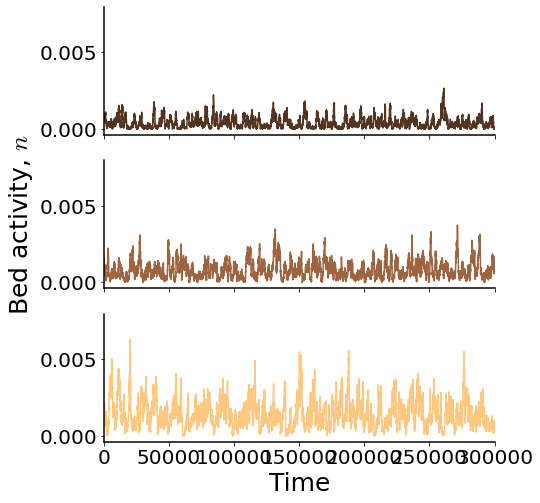

In [28]:
# Choose directory
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot = [
#     'q_1d000000e-01', ##
#     'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', ##
#     'q_3d414549e-01', 
#     'q_4d641589e-01', 
#     'q_6d309573e-01', ##
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
#     'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

nbin = 15
multf = 100
yint = 0.0

fig,ax = plt.subplots(3,1,figsize=(7,8),sharex='col',sharey='col')

for ii,run in enumerate(exp_plot):

    #####################
    #### TIME SERIES ####
    #####################
    for spine in ax[ii].spines.items():
        ax[ii].spines[spine[0]].set_linewidth(1.5)
    ax[ii].spines['right'].set_linewidth(0)
    ax[ii].spines['top'].set_linewidth(0)
    if ii==1:
#         ax[ii].set_ylabel(r"Sediment flux, $q^*$",fontsize=25)
        ax[ii].set_ylabel(r"Bed activity, $n$",fontsize=25)
    if ii==2:
        ax[ii].set_xlabel(r"Time",fontsize=25)
        #     plt.tight_layout()

        # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    t = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    q = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
    ### TIME SERIES
    ax[ii].plot(t-t[0],q,color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),label = r'$\langle q^*_{in} \rangle = $ %.3e' % q8_in)
#     tshift= t[0]
    deltat = 100000 #500000
    ax[ii].set_xlim(0,3*deltat)
#     ax[ii].set_ylim(0,0.02)
#     if ii==0:
#         ax[ii].legend(title="Input flux",loc=1)
#     else:
#         ax[ii].legend(loc=1)

###########################
# plt.savefig(odir+"Fig2_1_SIM.png",bbox_inches= "tight",dpi=300)

plt.show()

<ipython-input-26-1ff231595ef7>:103: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fff9bd30340> has a label of '_line3' which cannot be automatically added to the legend.
  first_legend = pdf_ax.legend(handles=tslope,frameon=False,loc=1,fontsize=25)


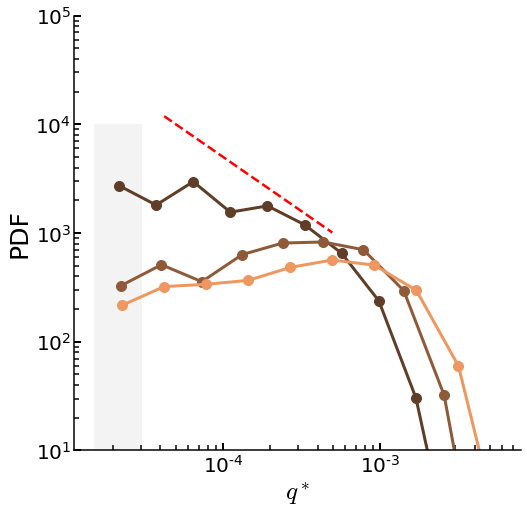

In [26]:
# Choose directory
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot = [
#     'q_1d000000e-01', ##
#     'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', ##
#     'q_3d414549e-01', 
#     'q_4d641589e-01', 
#     'q_6d309573e-01', ##
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
#     'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

nbin = 10
multf = 1
yint = 0.0


# Finite size effect cutoff
nbeads = 2# Number of grains considered 'too small'
xcutoff = nbeads/(Nx*Ny) # Five grains active total

# fig,(ax) = plt.subplots(1,1,figsize=(12,8))
fig, pdf_ax = plt.subplots(1,1,figsize=(8,8))
for ii,run in enumerate(exp_plot):
    # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    t = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    q = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
    pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin, output='pdf')#,xmin = xcutoff,xmax = max(q), output='pdf')
    plt.loglog(x[pdf>0],pdf[pdf>0],marker='o',lw=3,ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

#     plt.axvline(x= xcutoff,color='b')

    xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#     if run=='q_6d309573e-01':
#         # For plotting example gaussian
#         x = np.logspace(np.log10(2e-3),np.log10(max(q)),1000)
#         mean = np.nanmean(q)
#         std = np.nanstd(q)
#         gauss = pdf_ax.loglog(x,(1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*(x-mean)**2/std**2),ls = '--',c='grey',zorder=-10,lw=2.5,label="Gaussian")
    

# pdf_ax.set_ylim(1e-1,1e4)
pdf_ax.set_ylim(1e1,1e5)
# pdf_ax.set_xlim(2e-3,3)
pdf_ax.tick_params(axis='both',which = 'both',direction='in')#,width=2)
for spine in pdf_ax.spines.items():
    pdf_ax.spines[spine[0]].set_linewidth(1.5)
pdf_ax.spines['right'].set_linewidth(0)
pdf_ax.spines['top'].set_linewidth(0)
pdf_ax.tick_params(width=2,length=7,which='major')
pdf_ax.tick_params(width=1.5,length=5,which='minor')
pdf_ax.set_ylabel(r"PDF",fontsize=25)
pdf_ax.set_xlabel(r"$q^*$",fontsize=25)
# plt.text(2.5e-3,8e1, "g",fontsize=25)

yexp = -1.
tslope = pdf_ax.loglog(x[(xcutoff<x)&(x<9e-4)], 10**(-0.3)*x[(xcutoff<x)&(x<9e-4)]**(yexp),ls='--',color='r',lw=2.5)#,
#               label = 'Theoretical \n PDF exponent \n at threshold \n of motion',lw=2.5)
first_legend = pdf_ax.legend(handles=tslope,frameon=False,loc=1,fontsize=25)
pdf_ax.add_artist(first_legend)
# pdf_ax.legend(handles=gauss,frameon=False,loc=3,fontsize=25)

###########################
# plt.savefig(odir+"Fig2_2.png",bbox_inches= "tight",dpi=300)

plt.show()